In [1]:
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np
sys.path.append("../")
import preproc as preproc
import train as train
import tune as tune
import analysis as ana

Duplicate key in file '/Users/fu.j/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [2]:
# Same as Firnberg et al., 2014
AA_PROPERTY = {
    "W": "Aromatic",
    "F": "Aromatic",
    "Y": "Aromatic",
    "P": "Aliphatic",
    "M": "Aliphatic",
    "I": "Aliphatic",
    "L": "Aliphatic",
    "V": "Aliphatic",
    "A": "Aliphatic",
    "G": "Aliphatic",
    "C": "Polar uncharged",
    "S": "Polar uncharged",
    "T": "Polar uncharged",
    "Q": "Polar uncharged",
    "N": "Polar uncharged",
    "D": "Neg. charged",
    "E": "Neg. charged",
    "H": "Pos. charged",
    "R": "Pos. charged",
    "K": "Pos. charged",
}

# Protein property features (alanine scanning feature is not included).
DEMASK_FEATURES = ['entropy', 'log2f_var', 'matrix']

In [3]:
def preproc_demask_dmsas_data(input_data):
    """Impute, encode and weight DMS+AS data.
    """
    preproc_data = input_data.copy()
    preproc_data = preproc.impute_missing_value(preproc_data, None, ['AS_score'])
    # Encode wild-type & variant type amino acid with AS scores.
    preproc_data, encoded_col = preproc.encode_categorical_feature(preproc_data, ['aa1', 'aa2'], ['aa1', 'aa2'])
    preproc_data[encoded_col] = preproc_data[encoded_col].mul(preproc_data['AS_score'], axis='index')
    # Weight each variant.
    preproc_data = train.add_training_weight(preproc_data)
    return preproc_data, encoded_col

# Read data

DMS and AS data were normalised as mentioned in the Method that:
* Contain only single amino acid (alanine) substitution compared to the reference protein sequence
* score to 1 for wildtype-like variants
* score to 0 for nonsense-like variants

The `dataset_info` file contains the experimental information of DMS and AS data.

In [4]:
# Normalized DMS data and DeMaSk features. Keep 'NA' in wt_mut.
norm_dms = pd.read_csv('../data/normalized/normalized_dms_DeMaSk_features.csv', 
                       index_col=0, na_values=[''], keep_default_na=False)
norm_as = pd.read_csv('../data/normalized/normalized_alanine_scanning.csv')

data_info = pd.read_csv('../data/data_info/dataset_info.csv', index_col=0)

# Compare with published (on going)

To verify our re-implemented DeMaSk method, we compared the prediction result either using the published or our own (re-implemented) code & data.

We present the modelling & evaluation process for using our own code and data in the following cells.

Modelling with the published code and/or data were finished remotely and directly read in this notebook. __Code and results are available upon request.__

## Proposed

In [14]:
comp_model = dict()

In [15]:
# LOPO CV on all DMS collected with no AS data (Our data & code).

# Weight each mutatnt.
work_data = train.add_training_weight(norm_dms)

# Leave-one-protein-out cross-validation
test_perf = dict()
for unip in work_data['uniprot_id'].unique():  
    # Train.
    train_data = work_data.query("uniprot_id != @unip")
    test_data = work_data.query("uniprot_id == @unip")
    train_data, test_data = train.refit_matrix_score(train_data, test_data)
    
    # Predict.
    model_features = ['entropy', 'log2f_var', 'matrix']
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
    test_data['score_pred'] = predictor.predict(test_data[model_features])
    
    # Evaluate.
    for dms, df in test_data.groupby('dms_id'):
        test_perf[dms] = spearmanr(df['score'], df['score_pred'])[0]
comp_model['Our data & code'] = test_perf

In [18]:
# Collect results run by DeMaSk code. Code and results are not provided but available upon request.

#root = '/Users/fu.j/Documents/Codes_Data/demask/local_run'
#exp_id = {'DeMaSk data & code': 'demask_web', 'Our data & DeMaSk code': 'dv12_all_rank'}

for exp_name in ['DeMaSk data & code', 'Our data & DeMaSk code']:
    files = os.listdir(f"{root}/result/{exp_id[exp_name]}")
    exp_result = dict()
    for file in files:
        if file == '.DS_Store':
            continue
        predicted = pd.read_csv(f"{root}/result/{exp_id[exp_name]}/{file}", sep='\t')
        experimental = pd.read_csv(f"{root}/data/dms_data/{exp_id[exp_name]}/{file}", sep='\t')
        merged = pd.merge(experimental, predicted, on=['pos', 'WT', 'var'], suffixes=['_exp', '_pred'], 
                          how='left', validate='1:1').dropna()  # Remove nonsense variants.
        exp_result[file[:-4]] = spearmanr(merged['score_exp'], merged['score_pred'])[0]
    comp_model[exp_name] = exp_result

Prediction performance on each DMS dataset for modelling with published DeMaSk or our own code & data, creating __Figure S3__.

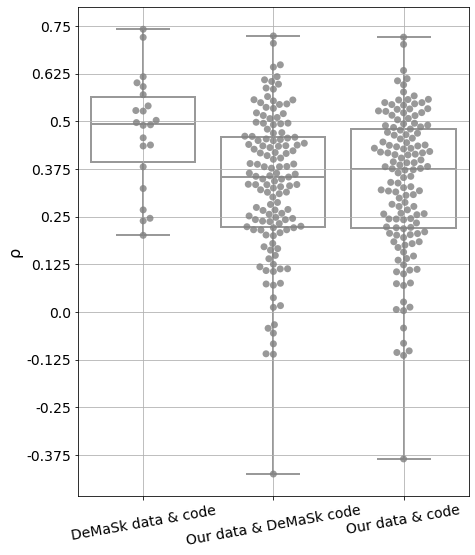

In [20]:
vis_data = pd.DataFrame(comp_model)

fig, ax = plt.subplots(1,1,figsize=(7,9), sharey=True)
fig.patch.set_facecolor('w')
order = ['DeMaSk data & code', 'Our data & DeMaSk code', 'Our data & code']
sns.swarmplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=7, alpha=0.8, zorder=2)
sns.boxplot(data=vis_data, color='w', ax=ax, whis=np.inf, order=order, linewidth=2, zorder=1)
ax.set_yticks(np.arange(-0.375,0.875,0.125))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_ylabel('ρ', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=10, fontsize=14)
ax.grid()
plt.show()

## Main

In [5]:
# DMS data from the same target should be merged according to DeMaSk website.
merge_group_web = [['urn:mavedb:00000047-a-1', 'ccr5-2d7-bind', 'ccr5-gp120cd4-bind'],
                   ['urn:mavedb:00000048-a-1', 'cxcr4-12g5-bind', 'cxcr4-cxcl12-bind'],
                   ['tp53-null-etop', 'tp53-null-nultlin'],
                   ['urn:mavedb:00000037-a-1'], 
                   ['urn:mavedb:00000038-a-1', 'urn:mavedb:00000038-b-1', 'urn:mavedb:00000038-b-2', 
                    'E1_Ubiquitin'],
                   ['urn:mavedb:00000086-a-1', 'urn:mavedb:00000086-b-1', 'urn:mavedb:00000086-c-1',
                    'urn:mavedb:00000086-d-1', 'urn:mavedb:00000086-e-1', 'urn:mavedb:00000086-f-1'],
                   ['urn:mavedb:00000070-a-2'],
                   ['urn:mavedb:00000001-a-2','urn:mavedb:00000001-a-3'],
                   ['urn:mavedb:00000001-b-2'],
                   ['urn:mavedb:00000001-c-1'], 
                   ['urn:mavedb:00000001-d-1']]
merged_dms = []
for group in merge_group_web:
    df = norm_dms.query("dms_id in @group").copy()
    df = df.groupby(['u_pos', 'aa1', 'aa2', 'uniprot_id', 'sub_type'], as_index=False).mean()
    df['dms_id'] = group[0]
    merged_dms.append(df)
merged_dms = pd.concat(merged_dms)

In [11]:
# Weight each mutant.
weight = merged_dms.groupby(['uniprot_id', 'u_pos', 'aa2'])['score'].count()
weight = 1 / weight
weight.name = 'weight'
merged_dms = pd.merge(merged_dms, weight, left_on=['uniprot_id', 'u_pos', 'aa2'], right_index=True,
                      how='outer', validate='m:1').reset_index(drop=True)

In [7]:
test_perf = dict()
for unip in merged_dms['uniprot_id'].unique():  # Leave-one-protein-out cross-validation
    # Train.
    train_data = merged_dms.query("uniprot_id != @unip")
    test_data = merged_dms.query("uniprot_id == @unip")
    train_data, test_data = train.refit_matrix_score(train_data, test_data)
    
    # Predict.
    model_features = ['entropy', 'log2f_var', 'matrix']
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
    test_data['score_pred'] = predictor.predict(test_data[model_features])
    
    # Evaluate.
    for dms, df in test_data.groupby('dms_id'):
        test_perf[dms] = spearmanr(df['score'], df['score_pred'])[0]

In [8]:
# Compare with result run by DeMaSk code.
root = '/Users/fu.j/Documents/Codes_Data/demask/local_run'
comp_model = {'own_code': test_perf}
for exp_name in ['demask_web_share', 'self_download_merge_web']:
    files = os.listdir(f"{root}/result/{exp_name}")
    exp_result = dict()
    for file in files:
        if file == '.DS_Store':
            continue
        predicted = pd.read_csv(f"{root}/result/{exp_name}/{file}", sep='\t')
        experimental = pd.read_csv(f"{root}/data/dms_data/{exp_name}/{file}", sep='\t')
        merged = pd.merge(experimental, predicted, on=['pos', 'WT', 'var'], suffixes=['_exp', '_pred'], 
                          how='left', validate='1:1').dropna()  # Nonsense variant exists.
        exp_result[file[:-4]] = spearmanr(merged['score_exp'], merged['score_pred'])[0]
    comp_model[exp_name] = exp_result

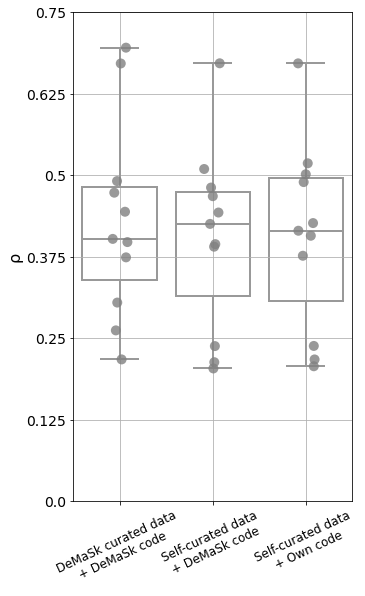

In [49]:
vis_data = pd.DataFrame(comp_model)
fig, ax = plt.subplots(1,1,figsize=(5,9), sharey=True)
order = ['demask_web_share', 'self_download_merge_web', 'own_code']
sns.stripplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=10, alpha=0.8)
sns.boxplot(data=vis_data, color='w', ax=ax, whis=np.inf, order=order, linewidth=2)
ax.set_yticks(np.arange(0,0.875,0.125))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_ylabel('ρ', fontsize=16)
ax.set_xticklabels(['DeMaSk curated data\n+ DeMaSk code', 'Self-curated data\n+ DeMaSk code', 
                    'Self-curated data\n+ Own code'], rotation=25, fontsize=12)
ax.grid()
plt.show()

## Extra

In [66]:
demask_curated = pd.read_csv('/Users/fu.j/AnacondaProjects/Project_3_extrapolation_model/data/dmsa_data/demask_train/demask_train_220311.csv',
                             index_col=0, na_values=[''], keep_default_na=False)
merge_group_demask= [['firnberg2014'],
                     ['giacomelli2018'],
                     ['heredia2018c'],
                     ['heredia2018x'],
                     ['roscoe2013'],
                     ['roscoe2014'],
                     ['stiffler2015'],
                     ['weile2017c'],
                     ['weile2017s'],
                     ['weile2017t'],
                     ['weile2017u']]
merged_dms = []
for group in merge_group_demask:
    df = demask_curated.query("dms_id in @group").copy()
    df = df.groupby(['dms_id', 'position', 'aa2', 'uniprot_id', 'aa1', 'sub_type'], as_index=False).first()[['uniprot_id', 'u_pos', 'aa2', 'entropy', 'log2f_var', 'matrix', 'score', 'dms_id', 'aa1', 'position', 'sub_type']]
    merged_dms.append(df)
merged_dms = pd.concat(merged_dms)

In [70]:
# Weight each mutatnt.
weight = merged_dms.groupby(['uniprot_id', 'u_pos', 'aa2'])['score'].count()
weight = 1 / weight
weight.name = 'weight'
merged_dms = pd.merge(merged_dms, weight, left_on=['uniprot_id', 'u_pos', 'aa2'], right_index=True,
                      how='outer', validate='m:1').reset_index(drop=True)

In [71]:
test_perf = dict()
for unip in merged_dms['uniprot_id'].unique():  # Leave-one-protein-out cross-validation
    # Train.
    train_data = merged_dms.query("uniprot_id != @unip")
    test_data = merged_dms.query("uniprot_id == @unip")
    train_data, test_data = train.refit_matrix_score(train_data, test_data)
    
    # Predict.
    model_features = ['entropy', 'log2f_var', 'matrix']
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
    test_data['score_pred'] = predictor.predict(test_data[model_features])
    
    # Evaluate.
    for dms, df in test_data.groupby('dms_id'):
        test_perf[dms] = spearmanr(df['score'], df['score_pred'])[0]
comp_model['own_code_demask_curated'] = test_perf

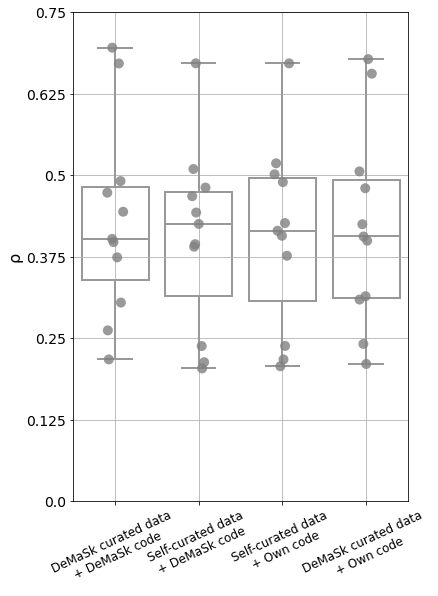

In [77]:
vis_data = pd.DataFrame(comp_model)
fig, ax = plt.subplots(1,1,figsize=(6,9), sharey=True)
order = ['demask_web_share', 'self_download_merge_web', 'own_code', 'own_code_demask_curated']
sns.stripplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=10, alpha=0.8)
sns.boxplot(data=vis_data, color='w', ax=ax, whis=np.inf, order=order, linewidth=2)
ax.set_yticks(np.arange(0,0.875,0.125))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_ylabel('ρ', fontsize=16)
ax.set_xticklabels(['DeMaSk curated data\n+ DeMaSk code', 'Self-curated data\n+ DeMaSk code', 
                    'Self-curated data\n+ Own code', 'DeMaSk curated data\n+ Own code'], rotation=25, fontsize=12)
ax.grid()
plt.show()

## DV12

In [17]:
# Weight each mutatnt.
weight = norm_dms.groupby(['uniprot_id', 'u_pos', 'aa2'])['score'].count()
weight = 1 / weight
weight.name = 'weight'
work_data = pd.merge(norm_dms, weight, left_on=['uniprot_id', 'u_pos', 'aa2'], right_index=True,
                      how='outer', validate='m:1').reset_index(drop=True)

test_perf = dict()
for unip in work_data['uniprot_id'].unique():  # Leave-one-protein-out cross-validation
    # Train.
    train_data = work_data.query("uniprot_id != @unip")
    test_data = work_data.query("uniprot_id == @unip")
    train_data, test_data = train.refit_matrix_score(train_data, test_data)
    
    # Predict.
    model_features = ['entropy', 'log2f_var', 'matrix']
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
    test_data['score_pred'] = predictor.predict(test_data[model_features])
    
    # Evaluate.
    for dms, df in test_data.groupby('dms_id'):
        test_perf[dms] = spearmanr(df['score'], df['score_pred'])[0]

In [100]:
# Compare with result run by DeMaSk code.
root = '/Users/fu.j/Documents/Codes_Data/demask/local_run'
comp_model = {'own_code': test_perf}
for exp_name in ['demask_web', 'dv12_all_rank']:
    files = os.listdir(f"{root}/result/{exp_name}")
    exp_result = dict()
    for file in files:
        if file == '.DS_Store':
            continue
        predicted = pd.read_csv(f"{root}/result/{exp_name}/{file}", sep='\t')
        experimental = pd.read_csv(f"{root}/data/dms_data/{exp_name}/{file}", sep='\t')
        merged = pd.merge(experimental, predicted, on=['pos', 'WT', 'var'], suffixes=['_exp', '_pred'], 
                          how='left', validate='1:1').dropna()  # Nonsense variant exists.
        exp_result[file[:-4]] = spearmanr(merged['score_exp'], merged['score_pred'])[0]
    comp_model[exp_name] = exp_result

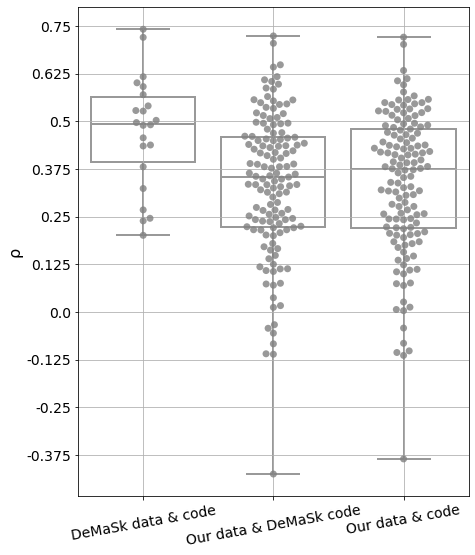

In [99]:
vis_data = pd.DataFrame(comp_model)
fig, ax = plt.subplots(1,1,figsize=(7,9), sharey=True)
order = ['demask_web', 'dv12_all_rank', 'own_code']
#sns.stripplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=10, alpha=0.5, jitter=0.2)
sns.swarmplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=7, alpha=0.8, zorder=2)
sns.boxplot(data=vis_data, color='w', ax=ax, whis=np.inf, order=order, linewidth=2, zorder=1)
ax.set_yticks(np.arange(-0.375,0.875,0.125))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_ylabel('ρ', fontsize=16)
ax.set_xticklabels(['DeMaSk data & code', 'Our data & DeMaSk code', 
                    'Our data & code'], rotation=10, fontsize=14)
ax.grid()
plt.show()

In [103]:
work_data = norm_dms.copy()
work_data['weight'] = 1

test_nonweight = dict()
for unip in work_data['uniprot_id'].unique():  # Leave-one-protein-out cross-validation
    # Train.
    train_data = work_data.query("uniprot_id != @unip")
    test_data = work_data.query("uniprot_id == @unip")
    train_data, test_data = train.refit_matrix_score(train_data, test_data)
    
    # Predict.
    model_features = ['entropy', 'log2f_var', 'matrix']
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
    test_data['score_pred'] = predictor.predict(test_data[model_features])
    
    # Evaluate.
    for dms, df in test_data.groupby('dms_id'):
        test_nonweight[dms] = spearmanr(df['score'], df['score_pred'])[0]

In [104]:
# Compare with result run by DeMaSk code.
root = '/Users/fu.j/Documents/Codes_Data/demask/local_run'
comp_model = {'own_code': test_perf, 'own_code_nonweight': test_nonweight}
for exp_name in ['demask_web', 'dv12_all_rank', 'dv12_all_nonrank']:
    files = os.listdir(f"{root}/result/{exp_name}")
    exp_result = dict()
    for file in files:
        if file == '.DS_Store':
            continue
        predicted = pd.read_csv(f"{root}/result/{exp_name}/{file}", sep='\t')
        experimental = pd.read_csv(f"{root}/data/dms_data/{exp_name}/{file}", sep='\t')
        merged = pd.merge(experimental, predicted, on=['pos', 'WT', 'var'], suffixes=['_exp', '_pred'], 
                          how='left', validate='1:1').dropna()  # Nonsense variant exists.
        exp_result[file[:-4]] = spearmanr(merged['score_exp'], merged['score_pred'])[0]
    comp_model[exp_name] = exp_result

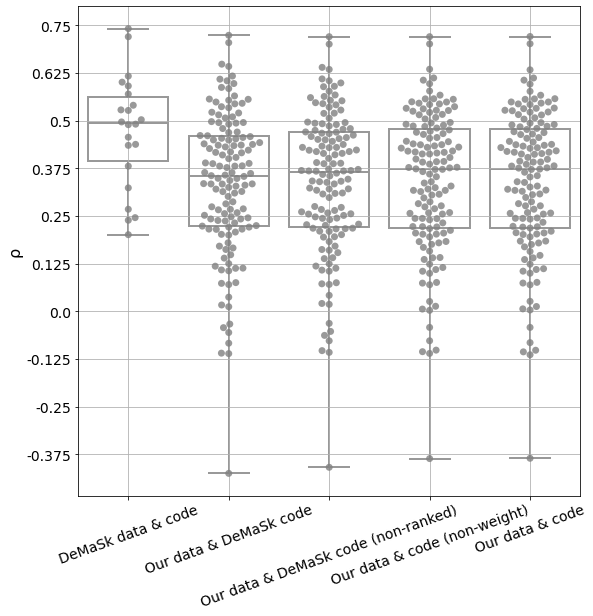

In [105]:
vis_data = pd.DataFrame(comp_model)
fig, ax = plt.subplots(1,1,figsize=(9,9), sharey=True)
order = ['demask_web', 'dv12_all_rank', 'dv12_all_nonrank', 'own_code_nonweight', 'own_code']
#sns.stripplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=10, alpha=0.5, jitter=0.2)
sns.swarmplot(data=vis_data, ax=ax, order=order, palette=['gray']*4, size=7, alpha=0.8, zorder=2)
sns.boxplot(data=vis_data, color='w', ax=ax, whis=np.inf, order=order, linewidth=2, zorder=1)
ax.set_yticks(np.arange(-0.375,0.875,0.125))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_ylabel('ρ', fontsize=16)
ax.set_xticklabels(['DeMaSk data & code', 'Our data & DeMaSk code', 'Our data & DeMaSk code (non-ranked)', 
                    'Our data & code (non-weight)', 'Our data & code'], rotation=20, fontsize=14)
ax.grid()
plt.show()

# Envision-based predictor (on going)

[Envision (Gray et al., 2018)](https://www.cell.com/cell-systems/fulltext/S2405-4712(17)30492-1) is one of the first DMS-based variant impact predictors. In this section, we managed to also improve Envision by incorporating AS data.

The data processing, modelling and evaluation follows a similar pipeline as the DeMaSk-based analysis.

## Data preparation

Features used in Envision were downloaded from either their published paper or its [online toolkit](https://envision.gs.washington.edu/shiny/envision_new/). Protein data were excluded if their feature values were not available. 

Missing feature values were imputed by the mean values for numerical features or the most frequent values for categorical features. Categorical features are encoded with the one-hot encoder. 

DMS and AS data pairs with high assay compatibility were used for modelling, with missing AS scores imputed by mean.

In [7]:
# Preprocess data: impute missing values and encode categorical features.
norm_dms_env = pd.read_csv('../data/normalized/normalized_dms_Envision_features.csv', 
                           index_col=0, na_values=[''], keep_default_na=False)

# All Envision features.
features = ['aa1', 'aa2', 'wt_mut', 'aa1_polarity', 'aa2_polarity', 'aa1_PI','aa2_PI', 'deltaPI', 
            'Grantham', 'aa1_weight', 'aa2_weight', 'deltaWeight', 'aa1vol', 'aa2vol', 'deltavolume',
            'aa1_psic', 'aa2_psic', 'delta_psic', 'accessibility', 'dssp_sec_str', 'phi_psi_reg',
            'delta_solvent_accessibility', 'b_factor', 'mut_msa_congruency', 'seq_ind_closest_mut', 
            'mut_mut_msa_congruency', 'evolutionary_coupling_avg']
categ_feat = ['aa1', 'aa2', 'wt_mut', 'aa1_polarity', 'aa2_polarity', 'dssp_sec_str', 'phi_psi_reg']
numer_feat = [x for x in features if x not in categ_feat]

norm_dms_env = preproc.impute_missing_value(norm_dms_env, categ_feat, numer_feat)
norm_dms_env, encoded_col = preproc.encode_categorical_feature(norm_dms_env, categ_feat, ['aa1', 'aa2'])
envision_features = encoded_col + numer_feat

In [8]:
# Pick AS subset that are highly compatibility with given DMS assay.

comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')

# Merge AS data and DMS data with Envision feature.
dmsas_env = pd.merge(norm_dms_env, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                     on=['dms_id', 'u_pos'], how='left')
dmsas_env['dmsa_id'] = dmsas_env['dms_id'] + '@' + dmsas_env['Ascan_id'].astype(str)
dmsas_env['Ascan_score_avail'] = ~dmsas_env['AS_score'].isna()
dmsas_env = preproc.impute_missing_value(dmsas_env, None, ['AS_score'])
dmsas_env = train.add_training_weight(dmsas_env)

## Modelling

### Envision-based model

The following code run the leave-one-protein-out cross-validation on DMS+AS data.
1. Data from each protein target in the DMS+AS data are picked as testing data.
2. The rest data were used for training.
3. Instead of Envision features, Extra AS scores and AS score availability (`Ascan_score_avail`) features were used to test if AS data can improve Envision model. 
4. Before the training process, we tune the hyper-parameters of the GradientBoostingRegressor by Bayesian optimisation with GroupKFold method (Group:protein ID, `K=30`) using training data.
4. Predictor using or not using AS data (together with the available feature) are trained separately and taken for prediction.

The demonstration and real tuning parameters are shown below. The later one was run on a high-performance computer that was supported by The University of Melbourne’s Research Computing Services and the Petascale Campus Initiative.

In [252]:
# Set tuning parameters.

# These are demonstration parameters which are much faster to run, but MAY STILL TAKE HOURS.
seed = 0
output_dir = '../result/prediction/alternative_models/envision/trial/'
# Hyper-parameter space to be optimized by tuning.
search_space = [{'name': 'n_estimators', 'type': 'discrete', 'domain': np.arange(1, 3), 'dtype': int},
                {'name': 'max_depth', 'type': 'discrete', 'domain': np.arange(1, 3), 'dtype': int}]
# Set arguments used by Bayesian Optimization model.
bo_kwargs = {'num_iterations': 1, 'num_cores': 1, 'if_maximize': True, 'random_seed': seed, 'max_time': 1000}
# Set arguments for cross-validation tuning.
cv_kwargs = {'scoring': 'neg_mean_squared_error', 'cv': GroupKFold(2), 'n_jobs': 4}

In [ ]:
"""
# This process was supported by The University of Melbourne’s Research Computing Services and 
# the Petascale Campus Initiative.

# These are the real parameters.
seed = 0
output_dir = '../result/prediction/alternative_models/envision/full_envision/'
search_space = [{'name':'n_estimators', 'type':'discrete', 'domain':np.arange(10, 61), 'dtype':int},
                {'name':'max_depth', 'type':'discrete', 'domain':np.arange(1, 81), 'dtype':int},
                {'name':'min_weight_fraction_leaf', 'type':'continuous', 'domain':(0.01,0.5), 'dtype':float}]
bo_kwargs = {'num_iterations': 500, 'num_cores': 1, 'if_maximize': True, 'random_seed': seed, 'max_time': 72000}
cv_kwargs = {'scoring': 'neg_mean_squared_error', 'cv': GroupKFold(30), 'n_jobs': 6}
"""

In [ ]:
# Leave-one-protein-out cross-validation
for unip in dmsas_env['uniprot_id'].unique():
    train_data = dmsas_env.query("uniprot_id != @unip")
    test_data_ori = dmsas_env.query("uniprot_id == @unip")
    cv_kwargs['fit_params'] = {'sample_weight': train_data['weight']}
    cv_kwargs['groups'] = train_data['uniprot_id']
    
    for model in ['with_as', 'no_as']:
        if model == 'with_as':
            # Extra feature of Ascan_score_avail indicates the availability of AS data.
            model_features = envision_features + ['AS_score', 'Ascan_score_avail']  
        else:
            model_features = envision_features.copy()
        output_header = f"{output_dir}{unip}_{model}_"
        bo_kwargs['output_header'] = output_header

        # Training & testing.
        estimator = GradientBoostingRegressor(random_state=seed)
        predictor = tune.fit_best_estimator(search_space, estimator, train_data[model_features], 
                                            train_data['score'], cv_kwargs, bo_kwargs)
        test_data = test_data_ori.copy()
        test_data['pred_score'] = predictor.predict(test_data[model_features])
        
        # Saving results.
        test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")
        tune.save_feature_importance(predictor, output_header)
        tune.save_tuned_hyperparameters(predictor, search_space, output_header)

### Comparison DeMaSk-based result

As mentioned, Envision feature are not available (provided online) for some proteins whose data wre removed from the above analysis.

So, for comparison, we repeated the DeMaSk-based analysis on the same subset of data.

In [50]:
# Build DeMaSk-based predictor on the same subset of data (some proteins have no Envision features available).

prot_with_envf = norm_dms_env.uniprot_id.unique()  # Proteins with Envision feature.
overlap_data = norm_dms.query("uniprot_id in @prot_with_envf")

comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')

dmsas_dem = pd.merge(overlap_data, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                     on=['dms_id', 'u_pos'], how='left')
dmsas_dem['dmsa_id'] = dmsas_dem['dms_id'] + '@' + dmsas_dem['Ascan_id'].astype(str)
dmsas_dem['Ascan_score_avail'] = ~dmsas_dem['AS_score'].isna()
dmsas_dem, encoded_col = preproc_demask_dmsas_data(dmsas_dem)

In [13]:
output_dir = '../result/prediction/alternative_models/envision/demask_comparison/'
# Leave-one-protein-out cross-validation
for unip in dmsas_dem['uniprot_id'].unique():
    train_data = dmsas_dem.query("uniprot_id != @unip")
    test_data_ori = dmsas_dem.query("uniprot_id == @unip")
    train_data, test_data_ori = train.refit_matrix_score(train_data, test_data_ori)

    for model in ['with_as', 'no_as']:
        output_header = f"{output_dir}{unip}_{model}_"
        if model == 'with_as':
            model_features = DEMASK_FEATURES + encoded_col + ['AS_score']
        else:
            model_features = DEMASK_FEATURES.copy()

        estimator = LinearRegression(n_jobs=1)
        predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
        test_data = test_data_ori.copy()
        test_data['pred_score'] = predictor.predict(test_data[model_features])
        test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")

## Evaluation (proposed)

While reading the prediction result:
1. We collected the result predicted by either Envision-based or DeMaSk-based predictor.
2. The prediction result using AS data or not (control) were merged together for comparison.

In [74]:
def read_lopo_prediction_result(result_dir, target_proteins):
    """Read leave-one-protein-out cross-validation results for using AS data or not.
    """
    results = dict()
    for model in ['with_as', 'no_as']:
        results[model] = pd.concat([pd.read_csv(f"{result_dir}{unip}_{model}_prediction.csv", index_col=0) 
                                    for unip in target_proteins])
    pred_merge = pd.merge(results['with_as'], results['no_as'], on=["dmsa_id", "position", "aa2", "score"],
                          validate="1:1", suffixes=["_ala", "_noala"], how='outer')
    return pred_merge

In [75]:
#env_based_pred = read_lopo_prediction_result('../result/prediction/alternative_models/envision/full_envision/', 
#                                             dmsas_env.uniprot_id.unique())
env_based_pred = read_lopo_prediction_result('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/15_avail_comp/log/',
                                             dmsas_env[dmsas_env['Ascan_score_avail']].uniprot_id.unique())
dem_based_pred = read_lopo_prediction_result('../result/prediction/alternative_models/envision/demask_comparison/',
                                             dmsas_env.uniprot_id.unique())

While evaluating the prediction performance:
1. We evaluate the performance by calculating the Spearman's ρ between the experimental score (`score`) and prediction result (`pred_score_ala` or `pred_score_noala`).
2. This calculation was done for each pair of DMS-AS data, identified by `dmsa_id`.
3. Performance change is calculated from the correlation change for prediction result using AS data or not.

In [76]:
# Evaluate performance with Spearman's ρ on each DMS-AS pair.
model_perform = []
for model, pred_result in {'Envision-based ± AS': env_based_pred, 'DeMaSk-based ± AS': dem_based_pred}.items():
    perf_with_as = ana.subgroup_spearmanr(pred_result, 'dmsa_id', 'score', 'pred_score_ala')
    perf_no_as = ana.subgroup_spearmanr(pred_result, 'dmsa_id', 'score', 'pred_score_noala')
    perf_merge = pd.merge(perf_with_as, perf_no_as[['rho']], left_index=True, right_index=True, validate="1:1", 
                          suffixes=["_ala", "_noala"], how='outer')
    perf_merge['model'] = model
    model_perform.append(perf_merge)
model_perform = pd.concat(model_perform)

# Post process.
model_perform.rename(columns={'rho_ala': 'With AS', 'rho_noala': 'No AS'}, inplace=True)
model_perform['diff_spear'] = model_perform['With AS'] - model_perform['No AS']
model_perform = pd.merge(model_perform, data_info, left_index=True, right_on='dmsa_id', how='left', validate='m:1')

In [77]:
if_one_residue = dmsas_env.groupby('dmsa_id')['u_pos'].nunique()
one_residue_filter = if_one_residue[if_one_residue == 1].index

The following code show the performance change (measured by the difference of prediction correlation while using AS data or not) for either Envision-based or DeMaSk-based result, creating __Figure S8__.

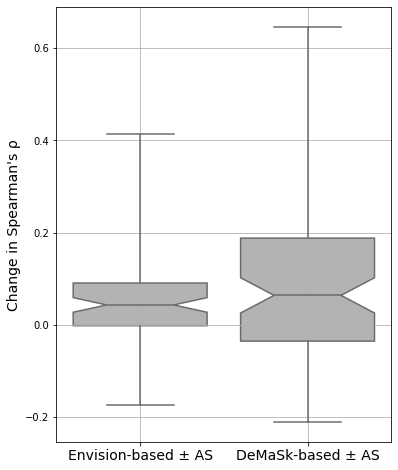

In [78]:
vis_data = model_perform[model_perform['Ascan_id'].notna()].query("dmsa_id not in @one_residue_filter")

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

## Trials

In [5]:
def read_lopo_prediction_result(result_dir, target_proteins):
    """Read leave-one-protein-out cross-validation results for using AS data or not.
    """
    results = dict()
    for model in ['with_as', 'no_as']:
        results[model] = pd.concat([pd.read_csv(f"{result_dir}{unip}_{model}_prediction.csv", index_col=0) 
                                    for unip in target_proteins])
    pred_merge = pd.merge(results['with_as'], results['no_as'], on=["dmsa_id", "position", "aa2", "score"],
                          validate="1:1", suffixes=["_ala", "_noala"], how='outer')
    return pred_merge

In [5]:
"""def read_lopo_prediction_result(result_dir, target_proteins):
    """Read leave-one-protein-out cross-validation results for using AS data or not.
    """
    results = dict()
    for model in ['with_as', 'no_as']:
        dfs = []
        for unip in target_proteins:
            try:
                dfs.append(pd.read_csv(f"{result_dir}{unip}_{model}_prediction.csv", index_col=0))
            except FileNotFoundError:
                continue
            
        results[model] = pd.concat(dfs)
    pred_merge = pd.merge(results['with_as'], results['no_as'], on=["dmsa_id", "position", "aa2", "score"],
                          validate="1:1", suffixes=["_ala", "_noala"], how='outer')
    return pred_merge"""

In [9]:
#env_based_pred = read_lopo_prediction_result('../result/prediction/alternative_models/envision/full_envision/', 
#                                             dmsas_env.uniprot_id.unique())
env_based_pred = read_lopo_prediction_result('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/20_19_avail_only/log/',
                                             dmsas_env[dmsas_env['Ascan_score_avail']].uniprot_id.unique())
dem_based_pred = read_lopo_prediction_result('../result/prediction/alternative_models/envision/demask_comparison/',
                                             dmsas_env.uniprot_id.unique())
#dem_based_pred = read_lopo_prediction_result('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/15_avail_comp/log/',
#                                             dmsas_env[dmsas_env['Ascan_score_avail']].uniprot_id.unique())

In [10]:
# Evaluate performance with Spearman's ρ on each DMS-AS pair.
model_perform = []
for model, pred_result in {'Envision-based ± AS': env_based_pred, 'DeMaSk-based ± AS': dem_based_pred}.items():
    perf_with_as = ana.subgroup_spearmanr(pred_result, 'dmsa_id', 'score', 'pred_score_ala')
    perf_no_as = ana.subgroup_spearmanr(pred_result, 'dmsa_id', 'score', 'pred_score_noala')
    perf_merge = pd.merge(perf_with_as, perf_no_as[['rho']], left_index=True, right_index=True, validate="1:1", 
                          suffixes=["_ala", "_noala"], how='outer')
    perf_merge['model'] = model
    model_perform.append(perf_merge)
model_perform = pd.concat(model_perform)

# Post process.
model_perform.rename(columns={'rho_ala': 'With AS', 'rho_noala': 'No AS'}, inplace=True)
model_perform['diff_spear'] = model_perform['With AS'] - model_perform['No AS']
model_perform = pd.merge(model_perform, data_info, left_index=True, right_on='dmsa_id', how='left', validate='m:1')

In [11]:
if_one_residue = dmsas_env.groupby('dmsa_id')['u_pos'].nunique()
one_residue_filter = if_one_residue[if_one_residue == 1].index

In [12]:
def foo_run_perf(data):
    # Remove data that no or only one one residue has (filtered) AS score.
    vis_data = data[~data['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")

    fig, ax = plt.subplots(1,1,figsize=(6, 8))
    fig.patch.set_facecolor('w')
    sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
    ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
    ax.set_xlabel('')
    ax.grid()
    plt.show()
    
    # Remove data that no or only one one residue has (filtered) AS score.
    vis_data = data[~data['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")
    vis_data = vis_data.melt(id_vars=['dmsa_id', 'model', 'size'], value_vars=['No AS', 'With AS'], value_name='spear', 
                             var_name='Feature')

    fig, ax = plt.subplots(1,1,figsize=(6, 8))
    fig.patch.set_facecolor('w')
    sns.boxplot(data=vis_data, x='model', y='spear', hue='Feature', palette='Set2', notch=True, whis=np.inf, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_ylabel('Prediction Spearman\'s ρ', fontsize=14)
    ax.set_xlabel('')
    ax.legend(loc=[0.72,0.02], fontsize=12)
    ax.grid()
    plt.show()

### 131320

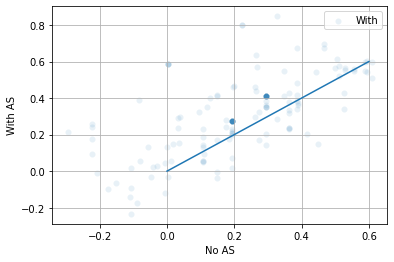

In [17]:
sns.scatterplot(data=model_perform[model_perform['Ascan_id'].notna()].query("model == 'Envision-based ± AS' \
                                                                       "), 
                x='No AS', y='With AS', label='With', alpha=0.1)
plt.grid()
plt.plot([0,.6],[0,.6])
plt.show()

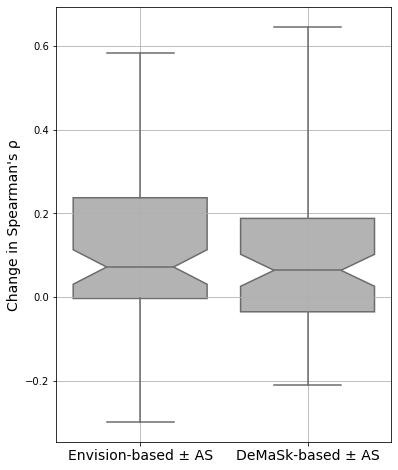

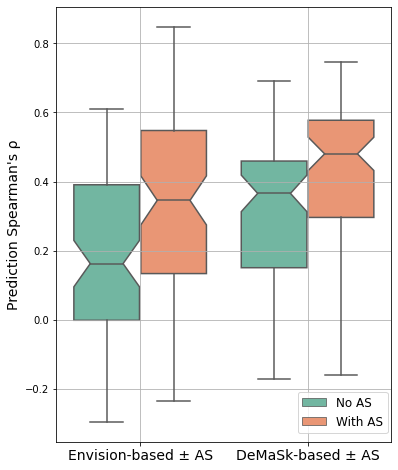

In [13]:
foo_run_perf(model_perform)

### 131319

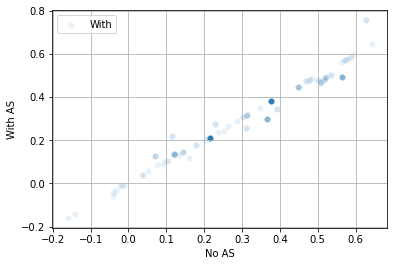

In [14]:
sns.scatterplot(data=model_perform[model_perform['Ascan_id'].notna()].query("model == 'Envision-based ± AS' \
                                                                       "), 
                x='No AS', y='With AS', label='With', alpha=0.1)
plt.grid()
plt.show()

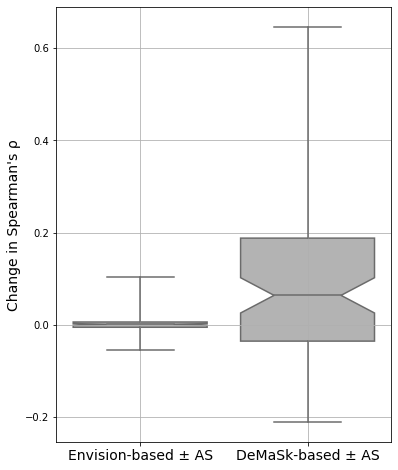

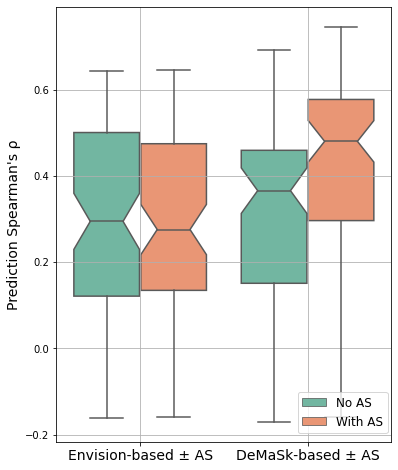

In [13]:
foo_run_perf(model_perform)

### 131318

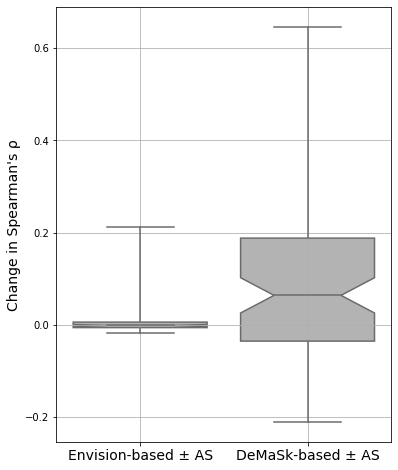

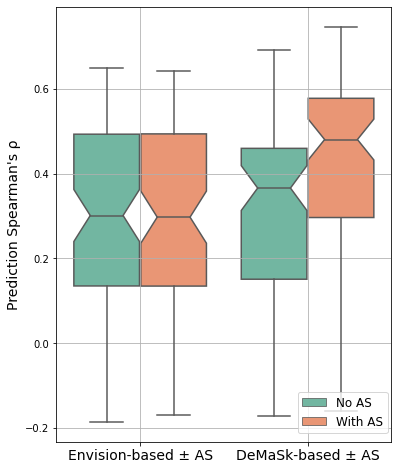

In [13]:
foo_run_perf(model_perform)

### 131317

Envision: 131317; DeMaSk: actually 131315

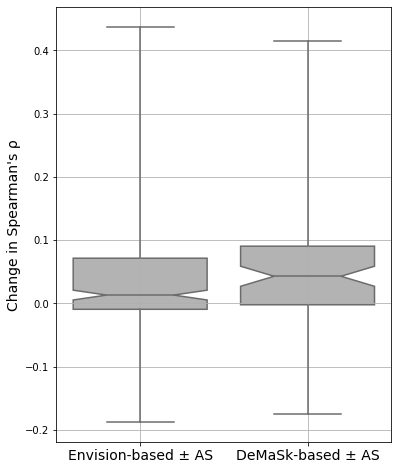

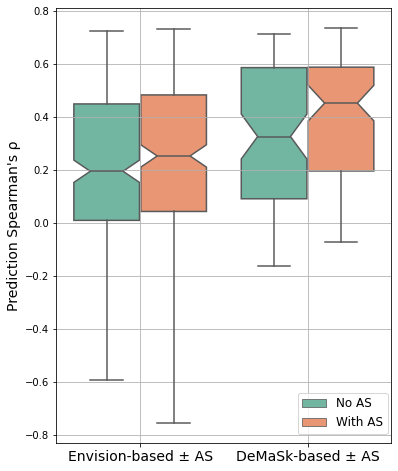

In [29]:
foo_run_perf(model_perform)

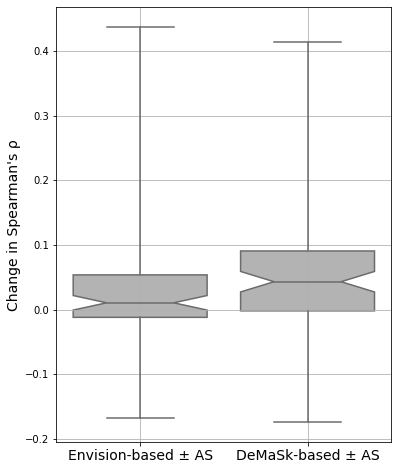

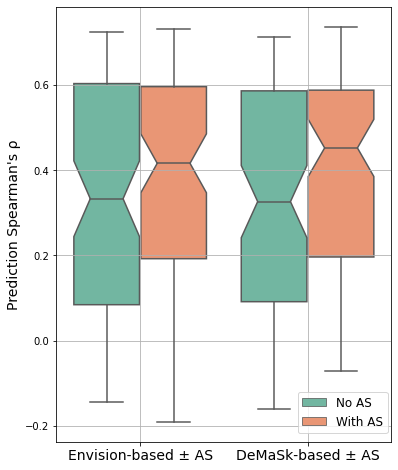

In [31]:
comp_dmsa = model_perform.query("model=='DeMaSk-based ± AS'").dmsa_id.unique()
foo_run_perf(model_perform.query("dmsa_id in @comp_dmsa"))

### 131316

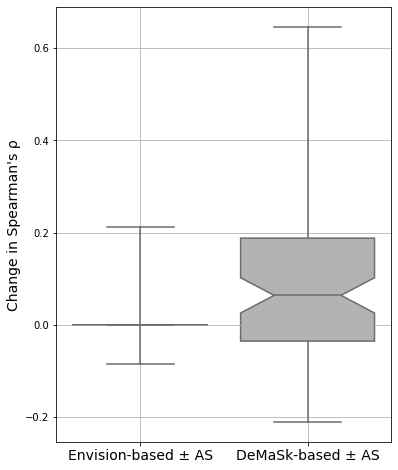

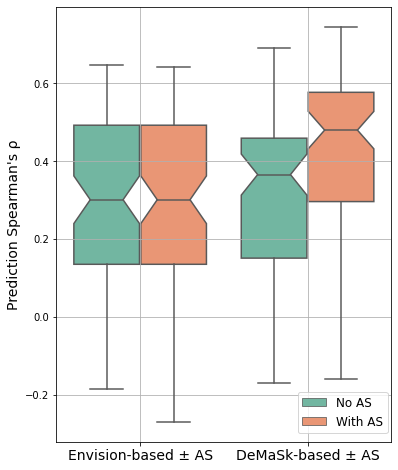

In [12]:
foo_run_perf(model_perform)

### 131315

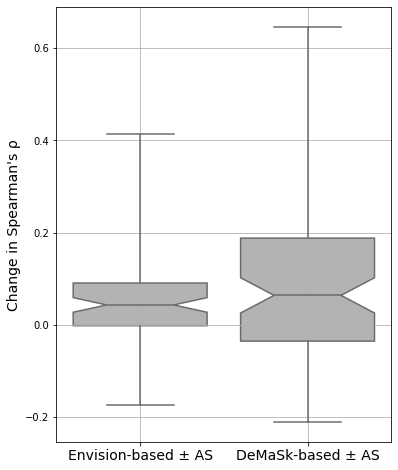

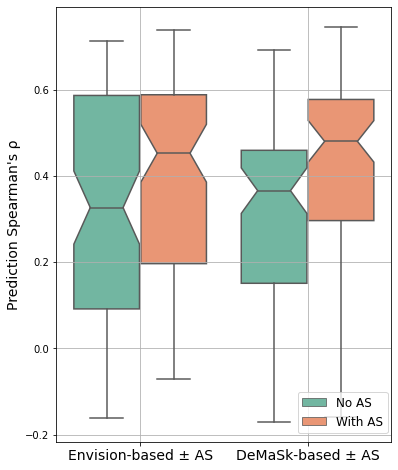

In [14]:
foo_run_perf(model_perform)

### 131313

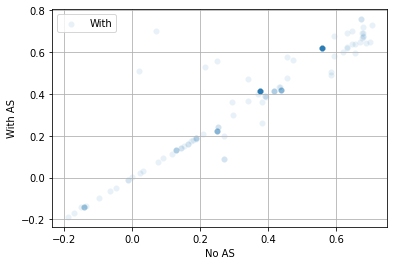

In [59]:
sns.scatterplot(data=model_perform[model_perform['Ascan_id'].notna()].query("model == 'Envision-based ± AS' \
                                                                       "), 
                x='No AS', y='With AS', label='With', alpha=0.1)
plt.grid()
plt.show()

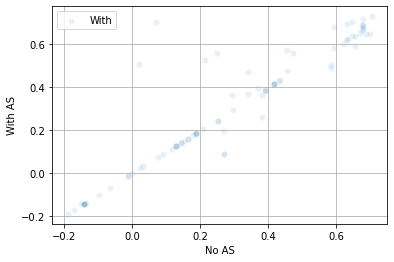

In [60]:
sns.scatterplot(data=model_perform[model_perform['Ascan_id'].notna()].query("model == 'Envision-based ± AS' \
                                                                        & dmsa_id not in @one_residue_filter"), 
                x='No AS', y='With AS', label='With', alpha=0.1)
plt.grid()
plt.show()

In [19]:
model_perform

,With AS,size,No AS,model,diff_spear,uniprot_id,dms_id,protein_name,dms_name,Ascan_id,dmsa_id,assumed_compatibility,regularized_correlation,n_ala,ala_score_correlation
22,0.528867,228.0,0.214070,Envision-based ± AS,0.314798,P38398,Brca1_E3,BRCA1,BRCA1_E3-Envision,brca1_mono_ub,Brca1_E3@brca1_mono_ub,High,0.603550,12.0,0.713287
27,0.180596,4629.0,0.181884,Envision-based ± AS,-0.001288,P38398,Brca1_E3,BRCA1,BRCA1_E3-Envision,NaN,Brca1_E3@nan,NaN,NaN,NaN,NaN
33,0.195295,1748.0,0.194753,Envision-based ± AS,0.000542,P38398,Brca1_Y2H,BRCA1,BRCA1_Y2H-Envision,NaN,Brca1_Y2H@nan,NaN,NaN,NaN,NaN
19,0.447357,1085.0,0.414159,Envision-based ± AS,0.033197,P0CG63,E1_Ubiquitin,Ubiquitin,UBI_Less-E1-Envision,NaN,E1_Ubiquitin@nan,NaN,NaN,NaN,NaN
373,0.399532,489.0,0.369568,Envision-based ± AS,0.029964,P05067,ab42,Abeta42,Abeta42,ab40_ddg,ab42@ab40_ddg,High,0.432489,26.0,0.467088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0.019029,361.0,0.019029,DeMaSk-based ± AS,0.000000,P61073,urn:mavedb:00000048-a-1,CXCR4,CXCR4-expression,cxcr4_tian_sdf1a,urn:mavedb:00000048-a-1@cxcr4_tian_sdf1a,Medium,0.122476,19.0,0.136084
275,0.165295,1348.0,0.165295,DeMaSk-based ± AS,0.000000,P61073,urn:mavedb:00000048-a-1,CXCR4,CXCR4-expression,cxcr4_trent_896,urn:mavedb:00000048-a-1@cxcr4_trent_896,Low,-0.013501,71.0,-0.013887
276,0.232150,4974.0,0.232150,DeMaSk-based ± AS,0.000000,P61073,urn:mavedb:00000048-a-1,CXCR4,CXCR4-expression,NaN,urn:mavedb:00000048-a-1@nan,NaN,NaN,NaN,NaN
421,0.414889,6652.0,0.421934,DeMaSk-based ± AS,-0.007045,P60484,urn:mavedb:00000054-a-1,PTEN,PTEN_Phosphatase,NaN,urn:mavedb:00000054-a-1@nan,NaN,NaN,NaN,NaN


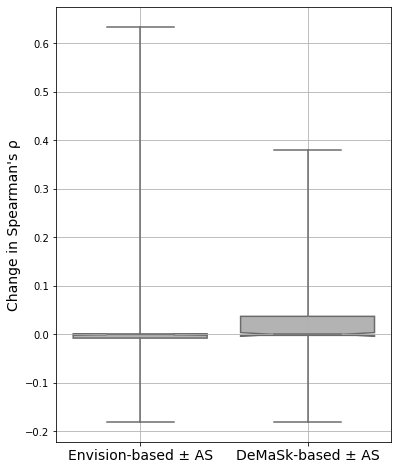

In [18]:
vis_data = model_perform[~model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

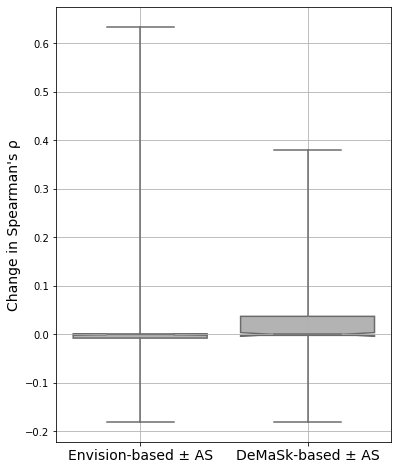

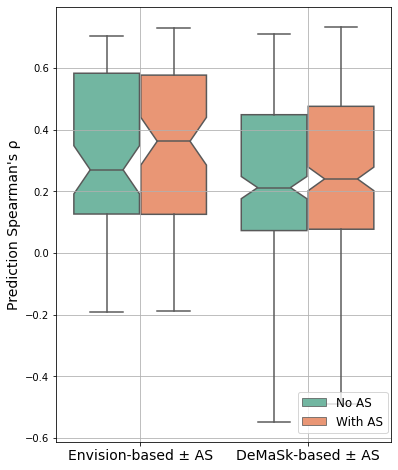

In [14]:
foo_run_perf(model_perform)

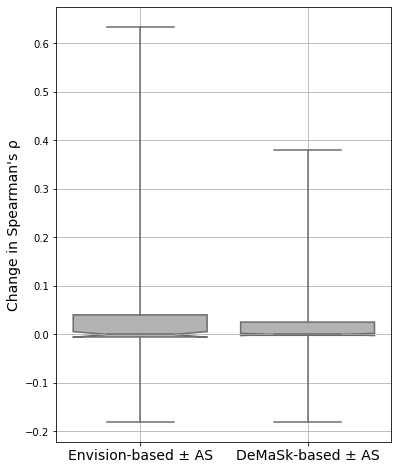

In [13]:
vis_data = model_perform[~model_perform['Ascan_id'].isna()]
fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

### 131311

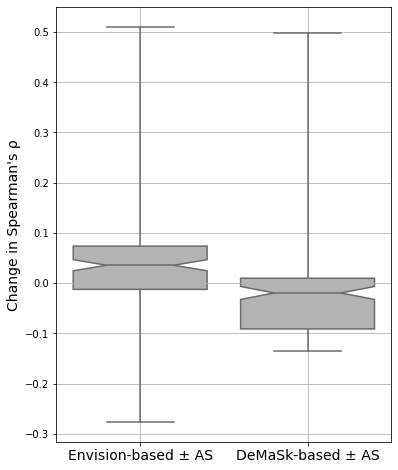

In [25]:
vis_data = model_perform[~model_perform['Ascan_id'].isna()]#.query("dmsa_id not in @one_residue_filter")
comp_as_id = model_perform.query("model == 'Envision-based ± AS'").dmsa_id.unique()
vis_data = vis_data.query("dmsa_id in @comp_as_id")

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

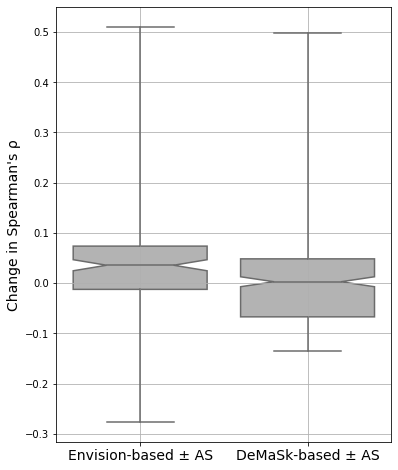

In [21]:
vis_data = model_perform[~model_perform['Ascan_id'].isna()]
fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

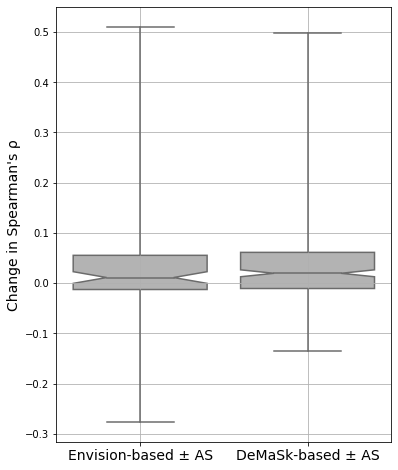

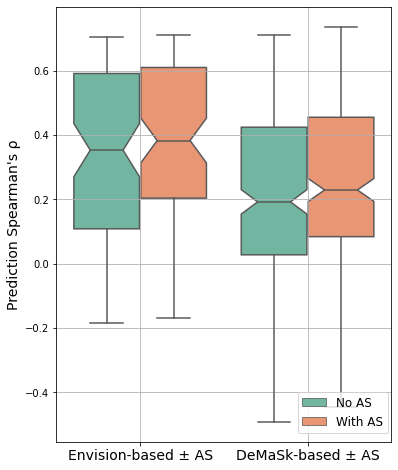

In [22]:
foo_run_perf(model_perform)

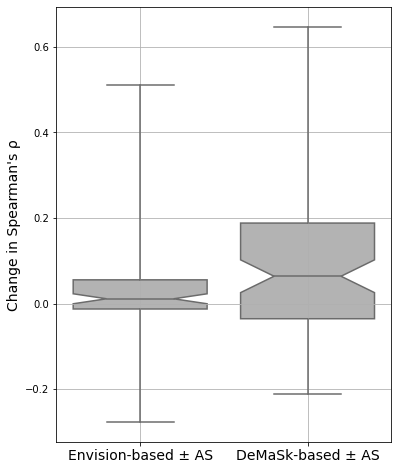

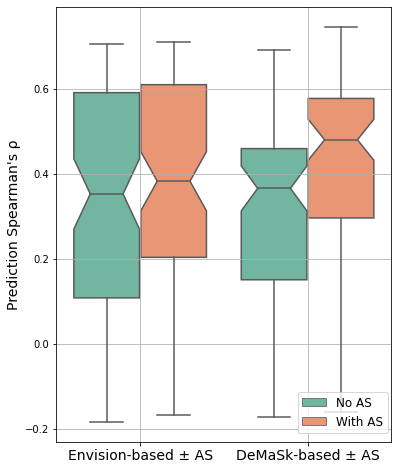

In [63]:
foo_run_perf(model_perform)

### 131310

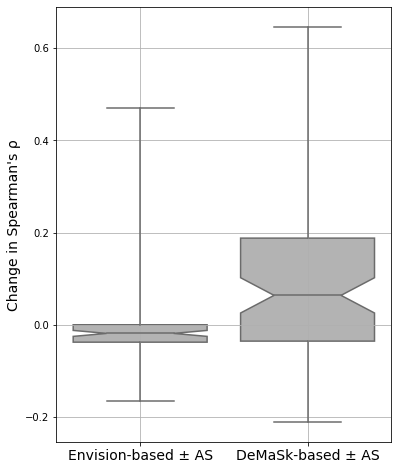

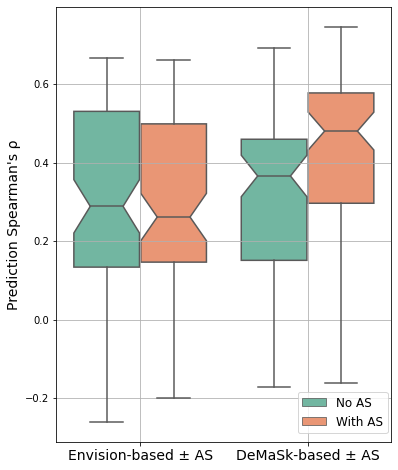

In [259]:
foo_run_perf(model_perform)

### 131309

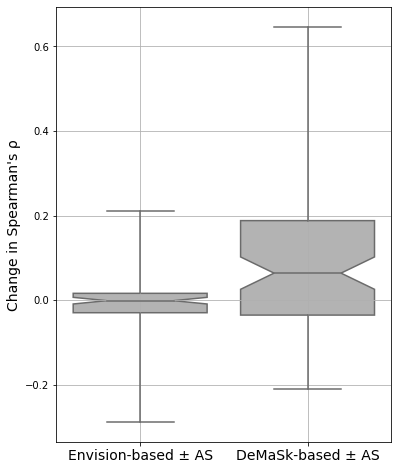

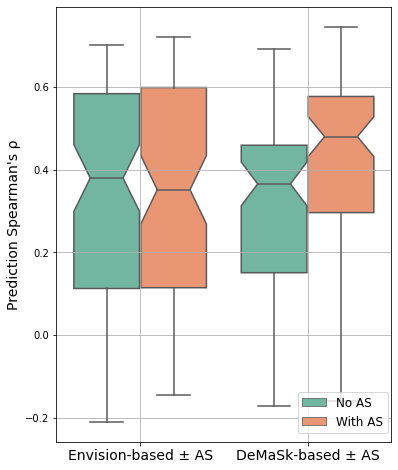

In [34]:
foo_run_perf(model_perform)

### 131308

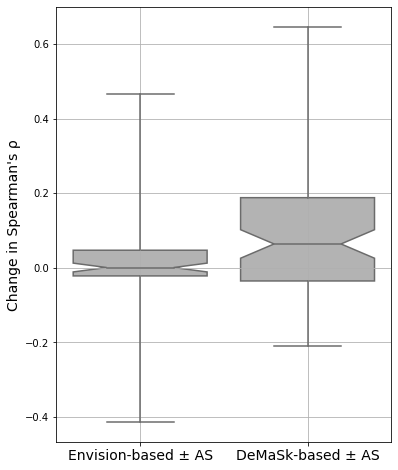

In [36]:
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = model_perform[~model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

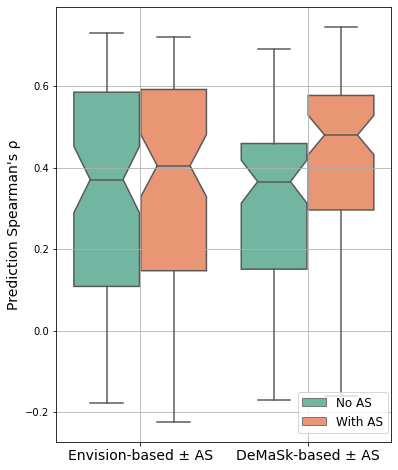

In [37]:
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = model_perform[~model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")
vis_data = vis_data.melt(id_vars=['dmsa_id', 'model', 'size'], value_vars=['No AS', 'With AS'], value_name='spear', 
                         var_name='Feature')

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='spear', hue='Feature', palette='Set2', notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_ylabel('Prediction Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.legend(loc=[0.72,0.02], fontsize=12)
ax.grid()
plt.show()

In [408]:
"""def read_foo(result_dir, target_proteins):
    """Read leave-one-protein-out cross-validation results for using AS data or not.
    """
    results = dict()
    for model in ['with_ala', 'nothing']:
        results[model] = pd.concat([pd.read_csv(f"{result_dir}{unip}_{model}_0_test_prediction.csv", index_col=0) 
                                    for unip in target_proteins]).rename(columns={'ob_score': 'score'})
    pred_merge = pd.merge(results['with_ala'], results['nothing'], on=["dmsa_id", "position", "aa2", "score"],
                          validate="1:1", suffixes=["_ala", "_noala"], how='outer')
    return pred_merge



env_based_pred = read_foo('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/08_v12_env/log/',
                                             dmsas_env[dmsas_env['Ascan_score_avail']].uniprot_id.unique())"""

In [277]:
"""def read_foo(result_dir, target_proteins):
    """Read leave-one-protein-out cross-validation results for using AS data or not.
    """
    results = dict()
    for model in ['with_ala', 'nothing']:
        results[model] = pd.concat([pd.read_csv(f"{result_dir}{unip}_{model}_0_test_prediction.csv", index_col=0) 
                                    for unip in target_proteins]).rename(columns={'ob_score': 'score'})
    pred_merge = pd.merge(results['with_ala'], results['nothing'], on=["dmsa_id", "position", "aa2", "score"],
                          validate="1:1", suffixes=["_ala", "_noala"], how='outer')
    return pred_merge



foo_pred = read_foo('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/06_05_rest/log/',
                                             dmsas_env[dmsas_env['Ascan_score_avail']].uniprot_id.unique())
perf_with_as = ana.subgroup_spearmanr(foo_pred, 'dmsa_id', 'score', 'pred_score_ala')
perf_no_as = ana.subgroup_spearmanr(foo_pred, 'dmsa_id', 'score', 'pred_score_noala')
perf_merge = pd.merge(perf_with_as, perf_no_as[['rho']], left_index=True, right_index=True, validate="1:1", 
                      suffixes=["_ala", "_noala"], how='outer')"""

In [278]:
exp_merge = pd.merge(perf_merge, model_perform.query("model=='Envision-based ± AS'"),
                     right_on='dmsa_id', left_index=True, validate='1:1', how='outer')
vis_data = exp_merge[exp_merge['Ascan_id'].notna()]

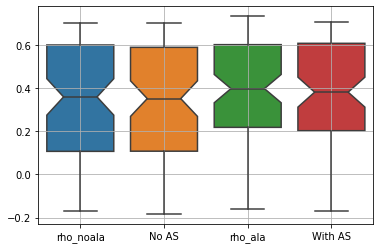

In [285]:
sns.boxplot(data=vis_data.query("dmsa_id not in @one_residue_filter")[['rho_noala','No AS','rho_ala','With AS']],notch=True)
plt.grid()
plt.show()

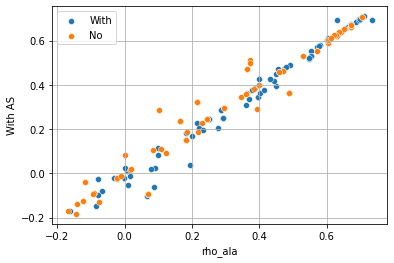

In [286]:
sns.scatterplot(data=vis_data.query("dmsa_id not in @one_residue_filter"), x='rho_ala', y='With AS', label='With')
sns.scatterplot(data=vis_data.query("dmsa_id not in @one_residue_filter"), x='rho_noala', y='No AS', label='No')
plt.legend()
plt.grid()
plt.show()

In [282]:
vis_data

,rho_ala,size_x,rho_noala,With AS,size_y,No AS,model,diff_spear,uniprot_id,dms_id,protein_name,dms_name,Ascan_id,dmsa_id,assumed_compatibility,regularized_correlation,n_ala,ala_score_correlation
22,0.554033,228.0,0.346531,0.554033,228.0,0.346531,Envision-based ± AS,0.207502,P38398,Brca1_E3,BRCA1,BRCA1_E3-Envision,brca1_mono_ub,Brca1_E3@brca1_mono_ub,High,0.603550,12.0,0.713287
373,0.386631,489.0,0.364253,0.386631,489.0,0.364253,Envision-based ± AS,0.022377,P05067,ab42,Abeta42,Abeta42,ab40_ddg,ab42@ab40_ddg,High,0.432489,26.0,0.467088
200,0.250147,266.0,0.245880,0.245880,266.0,0.245880,Envision-based ± AS,0.000000,Q9BYF1,ace2-s-high,ACE2,ACE2-s-high,ace2_han_20,ace2-s-high@ace2_han_20,High,0.226916,14.0,0.261826
201,0.250147,266.0,0.245880,0.245880,266.0,0.245880,Envision-based ± AS,0.000000,Q9BYF1,ace2-s-high,ACE2,ACE2-s-high,ace2_han_40_plasmid,ace2-s-high@ace2_han_40_plasmid,High,0.221440,14.0,0.255507
203,0.250147,266.0,0.245880,0.245880,266.0,0.245880,Envision-based ± AS,0.000000,Q9BYF1,ace2-s-high,ACE2,ACE2-s-high,ace2_han_60_plasmid,ace2-s-high@ace2_han_60_plasmid,High,0.051429,14.0,0.059341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,0.194799,627.0,0.015901,0.036998,627.0,0.015901,Envision-based ± AS,0.021097,P61073,urn:mavedb:00000048-a-1,CXCR4,CXCR4-expression,cxcr4_lin_exp44717,urn:mavedb:00000048-a-1@cxcr4_lin_exp44717,High,0.105580,33.0,0.112179
264,0.088343,76.0,-0.093838,-0.061136,76.0,-0.093838,Envision-based ± AS,0.032703,P61073,urn:mavedb:00000048-a-1,CXCR4,CXCR4-expression,cxcr4_lin_exp6h8,urn:mavedb:00000048-a-1@cxcr4_lin_exp6h8,High,-0.240000,4.0,-0.400000
269,0.067931,76.0,-0.124982,-0.102942,76.0,-0.124982,Envision-based ± AS,0.022040,P61073,urn:mavedb:00000048-a-1,CXCR4,CXCR4-expression,cxcr4_peng_exp,urn:mavedb:00000048-a-1@cxcr4_peng_exp,High,0.120000,4.0,0.200000
272,0.000245,418.0,0.020206,0.023846,418.0,0.020206,Envision-based ± AS,0.003640,P61073,urn:mavedb:00000048-a-1,CXCR4,CXCR4-expression,cxcr4_tian_exp,urn:mavedb:00000048-a-1@cxcr4_tian_exp,High,0.013920,22.0,0.015246


In [289]:
foo = vis_data.query("dmsa_id not in @one_residue_filter").copy()
foo['diff'] = foo['rho_ala'] - foo['With AS']
foo.sort_values('diff').tail(20)

,rho_ala,size_x,rho_noala,With AS,size_y,No AS,model,diff_spear,uniprot_id,dms_id,protein_name,dms_name,Ascan_id,dmsa_id,assumed_compatibility,regularized_correlation,n_ala,ala_score_correlation,diff
364,0.414093,304.0,0.371625,0.378135,304.0,0.497255,Envision-based ± AS,-0.119120,P51681,urn:mavedb:00000047-a-1,CCR5,CCR5-expression,ccr5_tan_exp,urn:mavedb:00000047-a-1@ccr5_tan_exp,High,0.339965,16.0,0.385294,0.035958
314,0.232432,320.0,0.165284,0.196411,320.0,0.237725,Envision-based ± AS,-0.041314,P51681,ccr5-gp120cd4-bind,CCR5,CCR5-gp120cd4-bind,ccr5_dragic_dh123,ccr5-gp120cd4-bind@ccr5_dragic_dh123,High,-0.185413,17.0,-0.208589,0.036021
333,0.401463,304.0,0.364945,0.362727,304.0,0.472810,Envision-based ± AS,-0.110083,P51681,ccr5-gp120cd4-bind,CCR5,CCR5-gp120cd4-bind,ccr5_tan_jrfl,ccr5-gp120cd4-bind@ccr5_tan_jrfl,High,0.090830,16.0,0.102941,0.038736
315,0.292547,320.0,0.165284,0.251802,320.0,0.237725,Envision-based ± AS,0.014077,P51681,ccr5-gp120cd4-bind,CCR5,CCR5-gp120cd4-bind,ccr5_dragic_jrfl,ccr5-gp120cd4-bind@ccr5_dragic_jrfl,High,-0.199469,17.0,-0.224402,0.040745
313,0.292547,320.0,0.165284,0.251802,320.0,0.237725,Envision-based ± AS,0.014077,P51681,ccr5-gp120cd4-bind,CCR5,CCR5-gp120cd4-bind,ccr5_dragic_ada,ccr5-gp120cd4-bind@ccr5_dragic_ada,High,-0.020710,17.0,-0.023299,0.040745
211,0.735093,75.0,0.705417,0.692984,75.0,0.705417,Envision-based ± AS,-0.012433,P61073,cxcr4-12g5-bind,CXCR4,CXCR4-12g5-bind,cxcr4_chabot_cys_4g10,cxcr4-12g5-bind@cxcr4_chabot_cys_4g10,High,0.569210,4.0,0.948683,0.042109
158,0.360849,190.0,0.296062,0.310218,190.0,0.296062,Envision-based ± AS,0.014157,Q9GZX7,aicda-g3,AICDA,AICDA-G3,aicda_gajula_growth,aicda-g3@aicda_gajula_growth,High,0.352066,10.0,0.430303,0.050630
304,0.396712,131.0,0.068505,0.344648,131.0,-0.092261,Envision-based ± AS,0.436909,P51681,ccr5-2d7-bind,CCR5,CCR5-2d7-bind,ccr5_zhang_roab12,ccr5-2d7-bind@ccr5_zhang_roab12,High,0.241071,7.0,0.321429,0.052064
303,0.396712,131.0,0.068505,0.344648,131.0,-0.092261,Envision-based ± AS,0.436909,P51681,ccr5-2d7-bind,CCR5,CCR5-2d7-bind,ccr5_zhang_2d7,ccr5-2d7-bind@ccr5_zhang_2d7,High,0.310823,7.0,0.414431,0.052064
306,0.396712,131.0,0.068505,0.344648,131.0,-0.092261,Envision-based ± AS,0.436909,P51681,ccr5-2d7-bind,CCR5,CCR5-2d7-bind,ccr5_zhang_roab14,ccr5-2d7-bind@ccr5_zhang_roab14,High,0.256767,7.0,0.342356,0.052064


## Tune optimization

In [18]:
def foo_run_hp(root):
    tune_report = dict()
    for file_name in os.listdir(root):
        if file_name[-10:] == 'report.txt':
            row = dict()
            with open(f"{root}{file_name}", 'r') as file:
                report = file.read()
            row['time'] = float(report.split('\n')[6].split(':')[1].strip().split(' ')[0])
            row['sample'] = int(report.split('\n')[3].split(':')[1].strip().split(',')[1].strip().split(' ')[0])
            opt_values = list(filter(None, report.split('\n')[-3].split(':')[1].strip().split(' ')))
            row['n_est'] = float(opt_values[0])
            row['max_depth'] = float(opt_values[1])
            row['leaf_weight'] = float(opt_values[2])
            tune_report[file_name[:-11]] = row
    for col in ['n_est', 'max_depth', 'leaf_weight']:
        sns.histplot(pd.DataFrame(tune_report).T[col])
        plt.show()
    return pd.DataFrame(tune_report).T.sort_values('sample')

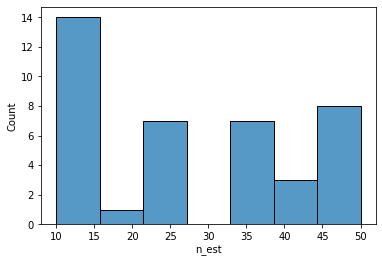

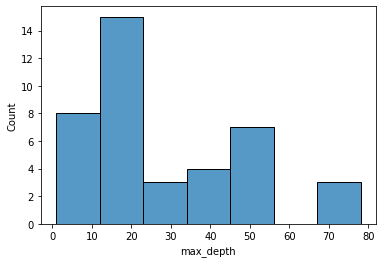

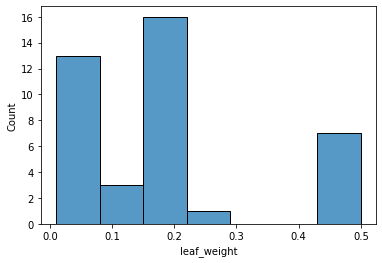

,time,sample,n_est,max_depth,leaf_weight
P04386_no_as,91.130978,19.0,11.0,25.0,0.010000
P04049_no_as,151.751101,22.0,12.0,38.0,0.150385
P61073_no_as,80.432076,24.0,10.0,42.0,0.010000
P60484_with_as,307.563805,25.0,50.0,5.0,0.010000
P04049_with_as,237.086144,34.0,48.0,13.0,0.208547
P05067_with_as,1481.285268,66.0,50.0,11.0,0.010883
P38398_no_as,1220.006053,139.0,15.0,39.0,0.015377
P05412_with_as,3054.215751,160.0,48.0,13.0,0.231137
P38398_with_as,2901.002949,178.0,48.0,6.0,0.035150
Q9BYF1_with_as,2843.404413,181.0,46.0,10.0,0.178102


In [19]:
foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/20_19_avail_only/log/')

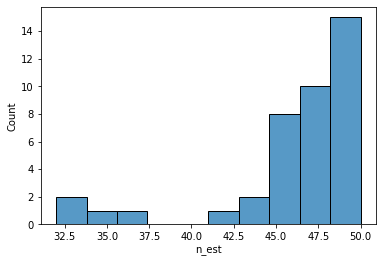

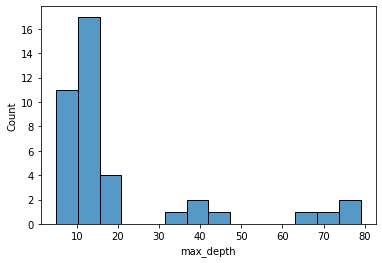

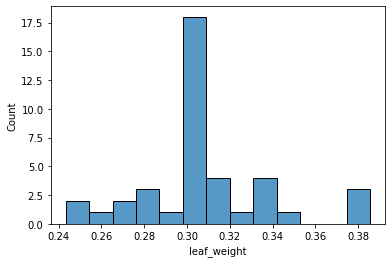

,time,sample,n_est,max_depth,leaf_weight
Q9BYF1_no_as,44328.664876,346.0,46.0,14.0,0.300422
P05412_no_as,41809.736988,347.0,50.0,14.0,0.312603
P04386_with_as,72596.262124,391.0,45.0,36.0,0.309927
P06654_no_as,65878.778985,395.0,45.0,14.0,0.308112
P40238_with_as,72199.589452,406.0,48.0,14.0,0.302524
P01112_no_as,72455.038378,422.0,50.0,13.0,0.282258
P63279_no_as,72386.614277,426.0,47.0,8.0,0.319459
P60484_with_as,72211.331563,437.0,49.0,13.0,0.347608
Q9GZX7_with_as,72019.396327,438.0,48.0,13.0,0.302034
P63279_with_as,72131.866374,446.0,45.0,7.0,0.319626


In [16]:
foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/18_16_avail_feat/log/')

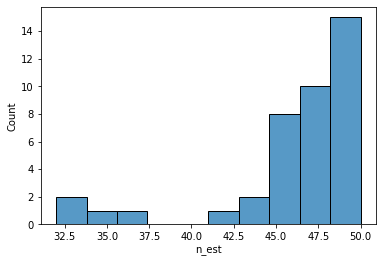

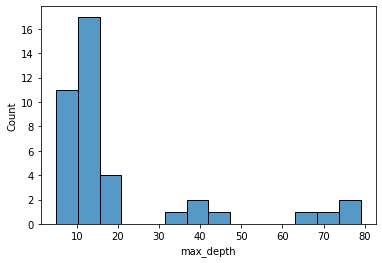

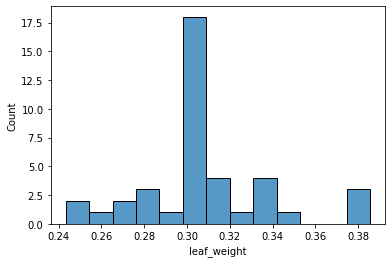

,time,sample,n_est,max_depth,leaf_weight
Q9BYF1_no_as,44328.664876,346.0,46.0,14.0,0.300422
P05412_no_as,41809.736988,347.0,50.0,14.0,0.312603
P04386_with_as,72596.262124,391.0,45.0,36.0,0.309927
P06654_no_as,65878.778985,395.0,45.0,14.0,0.308112
P40238_with_as,72199.589452,406.0,48.0,14.0,0.302524
P01112_no_as,72455.038378,422.0,50.0,13.0,0.282258
P63279_no_as,72386.614277,426.0,47.0,8.0,0.319459
P60484_with_as,72211.331563,437.0,49.0,13.0,0.347608
Q9GZX7_with_as,72019.396327,438.0,48.0,13.0,0.302034
P63279_with_as,72131.866374,446.0,45.0,7.0,0.319626


In [15]:
foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/18_16_avail_feat/log/')

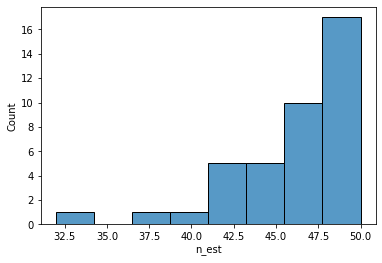

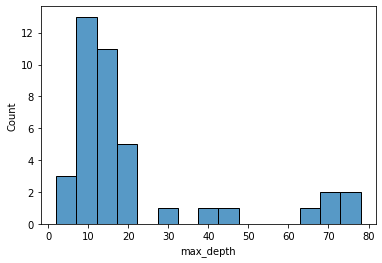

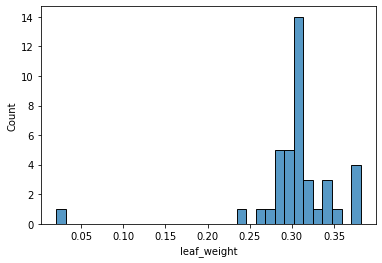

,time,sample,n_est,max_depth,leaf_weight
P60484_with_as,33890.000266,346.0,48.0,9.0,0.348274
Q9BYF1_no_as,39375.982334,346.0,46.0,14.0,0.300422
P05412_no_as,44166.099499,347.0,50.0,14.0,0.312603
P06654_no_as,60336.473474,395.0,45.0,14.0,0.308112
P61073_with_as,45714.999040,398.0,46.0,14.0,0.306558
P06654_with_as,66322.957175,438.0,47.0,18.0,0.305219
P01112_with_as,72319.371958,457.0,44.0,66.0,0.281430
P01112_no_as,72016.017330,459.0,45.0,75.0,0.280973
P04049_with_as,72080.356013,463.0,47.0,8.0,0.300563
P02724_no_as,67681.172168,475.0,43.0,11.0,0.301584


In [15]:
foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/16_limit_comp/log/')

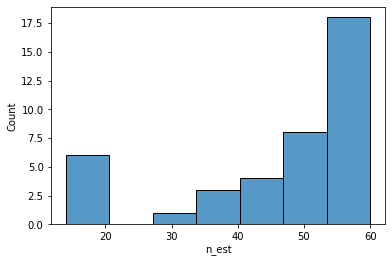

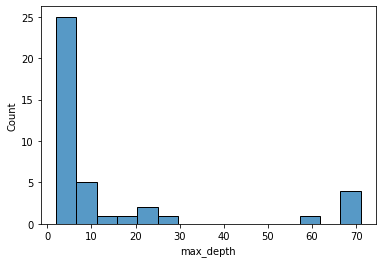

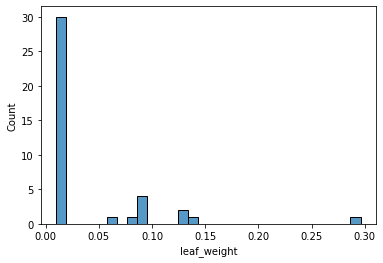

,time,sample,n_est,max_depth,leaf_weight
P35520_no_as,1402.773340,8.0,59.0,3.0,0.062974
P0CG63_with_as,24382.780400,25.0,15.0,71.0,0.010000
P01112_no_as,24882.520642,31.0,60.0,2.0,0.010000
Q9BYF1_with_as,36175.986795,32.0,14.0,71.0,0.010000
P63165_with_as,74449.030295,37.0,46.0,4.0,0.010000
P04637_with_as,74007.424257,39.0,42.0,6.0,0.010000
P63279_with_as,73228.817566,41.0,43.0,5.0,0.010000
P63279_no_as,74668.040154,46.0,40.0,4.0,0.010000
P04386_with_as,73182.120891,48.0,37.0,9.0,0.010000
P04049_with_as,72428.032782,49.0,50.0,3.0,0.010000


In [18]:
foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/15_avail_comp/log/')

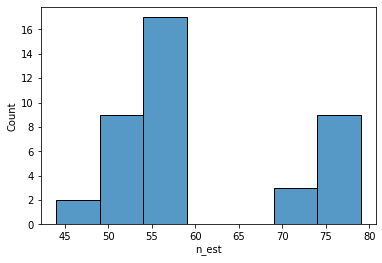

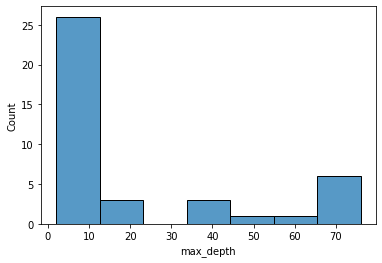

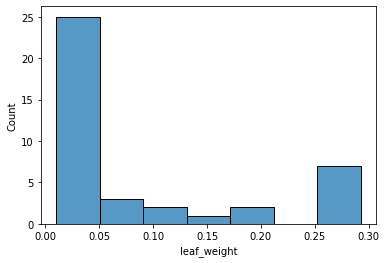

,time,sample,n_est,max_depth,leaf_weight
P40238_with_as,93043.044919,41.0,54.0,6.0,0.010000
P05412_with_as,146292.640517,50.0,56.0,3.0,0.010000
P38398_no_as,48711.323981,54.0,51.0,3.0,0.010000
P38398_with_as,144418.910075,57.0,49.0,3.0,0.010000
P05067_with_as,144399.618657,62.0,55.0,3.0,0.010000
P03069_with_as,144498.723069,64.0,51.0,4.0,0.010000
P40238_no_as,144246.732720,68.0,54.0,6.0,0.010000
P05067_no_as,144861.170201,73.0,54.0,3.0,0.010000
P35520_with_as,144607.567341,77.0,54.0,10.0,0.047268
Q9BYF1_no_as,147777.401470,79.0,77.0,71.0,0.288342


In [23]:
foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/13_tune2_comp/log/')

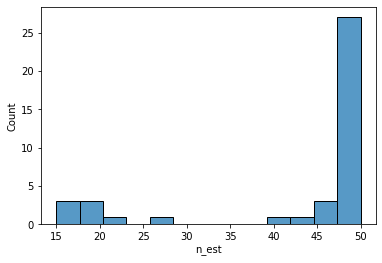

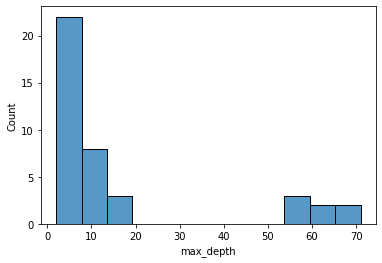

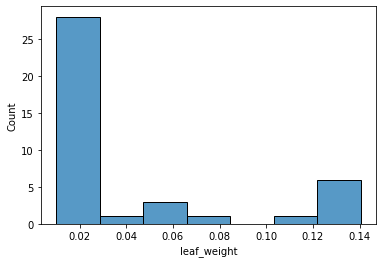

,time,sample,n_est,max_depth,leaf_weight
P04637_with_as,7982.469598,12.0,50.0,4.0,0.010000
P03069_no_as,8001.834249,15.0,49.0,14.0,0.122123
P03069_with_as,7933.001759,16.0,49.0,14.0,0.122123
P40238_no_as,23129.383414,24.0,19.0,59.0,0.010000
P51681_no_as,23448.466009,24.0,21.0,59.0,0.010000
P63165_no_as,25328.916262,27.0,47.0,11.0,0.042686
P63279_with_as,74256.429598,34.0,50.0,4.0,0.010000
P05412_with_as,75018.657632,39.0,49.0,13.0,0.140408
P35520_with_as,40072.331306,39.0,49.0,13.0,0.065067
Q9GZX7_with_as,73506.524525,42.0,50.0,3.0,0.010000


In [28]:
foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/12_11_all/log/')

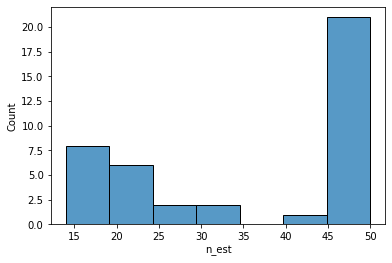

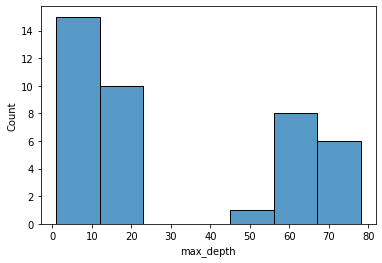

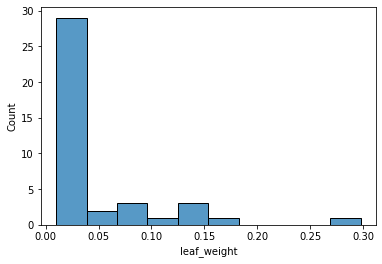

,time,sample,n_est,max_depth,leaf_weight
P51681_no_as,15954.709848,18.0,49.0,13.0,0.158433
P63165_no_as,15460.794506,21.0,20.0,60.0,0.010000
P04049_with_as,25878.854938,25.0,50.0,7.0,0.010000
Q9BYF1_no_as,21715.432302,30.0,15.0,74.0,0.010000
Q9BYF1_with_as,18461.976120,30.0,15.0,74.0,0.010000
P63165_with_as,72098.716375,31.0,26.0,78.0,0.010000
P04637_with_as,17810.675758,34.0,14.0,70.0,0.010000
P06654_with_as,22411.732641,34.0,19.0,59.0,0.010000
Q9GZX7_with_as,26441.329008,34.0,20.0,59.0,0.010000
P35520_no_as,74267.722064,38.0,46.0,13.0,0.064543


In [269]:
foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/11_10_structure_08_30_fold_reorder/log/')

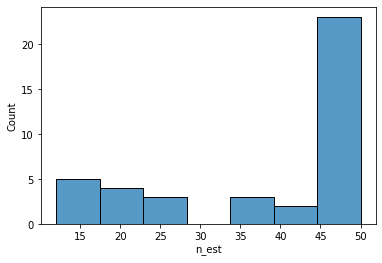

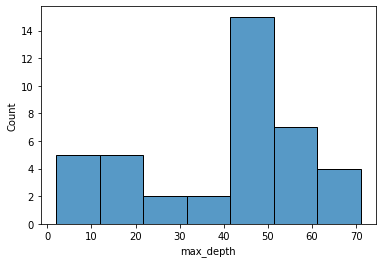

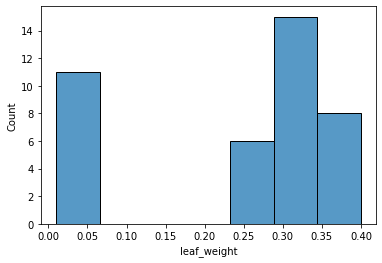

,time,sample,n_est,max_depth,leaf_weight
P05412_no_as,3651.932542,23.0,20.0,51.0,0.010000
Q9BYF1_no_as,1768.548733,26.0,17.0,59.0,0.256434
P05412_with_as,5805.358672,27.0,20.0,51.0,0.010000
P35520_no_as,4904.445651,28.0,47.0,2.0,0.010000
P01112_no_as,15242.886443,65.0,16.0,57.0,0.010000
P63165_no_as,17028.075032,74.0,17.0,56.0,0.010000
P63165_with_as,48902.839910,117.0,21.0,50.0,0.010000
P63279_with_as,64653.054596,158.0,18.0,51.0,0.010000
P04049_no_as,55032.227674,168.0,17.0,71.0,0.010625
P63279_no_as,72663.140274,191.0,24.0,5.0,0.010000


In [261]:
foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/10_08_5_fold/log/')

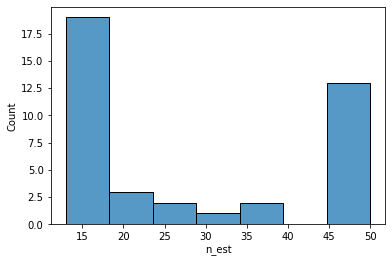

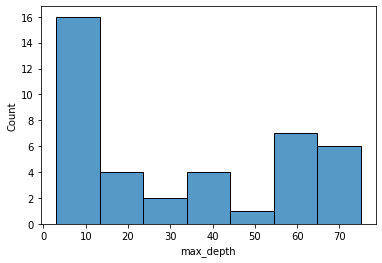

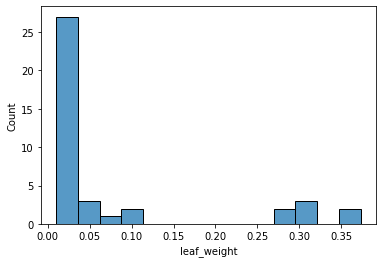

,time,sample,n_est,max_depth,leaf_weight
Q9GZX7_no_as,2346.176632,16.0,50.0,4.0,0.010000
Q9GZX7_with_as,2578.122726,17.0,50.0,4.0,0.010000
P63165_with_as,8049.701149,19.0,13.0,35.0,0.010000
P63165_no_as,8767.349254,19.0,13.0,35.0,0.010000
P06654_with_as,8829.679806,32.0,14.0,67.0,0.010000
Q9BYF1_no_as,13826.211291,56.0,49.0,14.0,0.292329
P40238_no_as,26273.680969,58.0,16.0,75.0,0.010000
Q9BYF1_with_as,16757.112847,58.0,49.0,14.0,0.292329
P61073_with_as,72128.322038,68.0,24.0,10.0,0.010000
P04049_no_as,17071.010192,69.0,16.0,72.0,0.012056


In [43]:
foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/09_08_10_fold/log/')

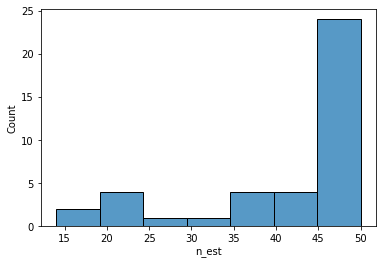

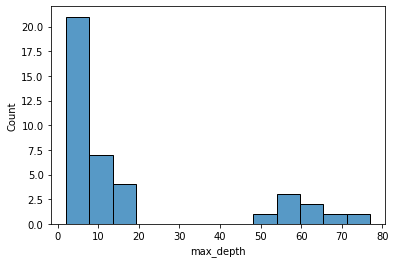

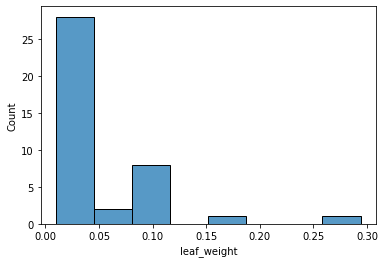

,time,sample,n_est,max_depth,leaf_weight
P05412_with_as,33883.431499,23.0,40.0,3.0,0.010000
Q9BYF1_no_as,15170.700512,26.0,49.0,13.0,0.161788
P40238_no_as,23761.771191,27.0,20.0,58.0,0.010000
P51681_with_as,74584.109040,33.0,36.0,8.0,0.010000
P05067_with_as,56244.188819,33.0,44.0,3.0,0.010000
P35520_with_as,73560.245174,34.0,44.0,7.0,0.010000
P03069_no_as,74887.175323,37.0,45.0,4.0,0.010000
P01112_with_as,48435.437926,38.0,48.0,5.0,0.010000
Q9GZX7_no_as,75269.487853,39.0,50.0,5.0,0.010000
P63165_with_as,72072.525123,39.0,37.0,6.0,0.010000


In [44]:
foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/08_220916_update/log/')

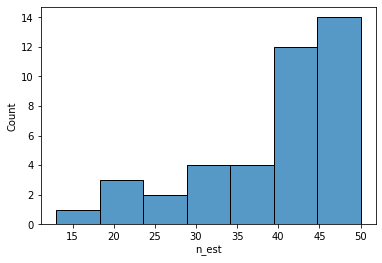

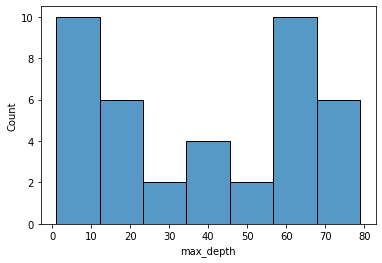

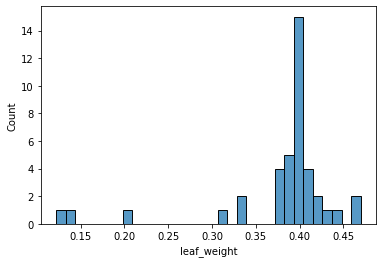

,time,sample,n_est,max_depth,leaf_weight
P60484_with_ala_0,5104.900359,104.0,20.0,60.0,0.414037
P60484_nothing_0,16017.497467,187.0,26.0,58.0,0.392979
P04049_with_ala_0,72151.133808,367.0,45.0,34.0,0.399549
P63279_nothing_0,72224.443636,383.0,46.0,16.0,0.422530
P63279_with_ala_0,72016.495184,389.0,48.0,11.0,0.419172
P05067_with_ala_0,72096.986166,389.0,43.0,69.0,0.402027
P02724_with_ala_0,72114.900214,399.0,36.0,60.0,0.399252
P0CG63_with_ala_0,61749.351326,403.0,49.0,13.0,0.387445
Q9GZX7_nothing_0,72199.557471,405.0,34.0,47.0,0.399704
P05412_nothing_0,72055.829874,408.0,34.0,72.0,0.407434


In [45]:
foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/08_v12_env/log/')

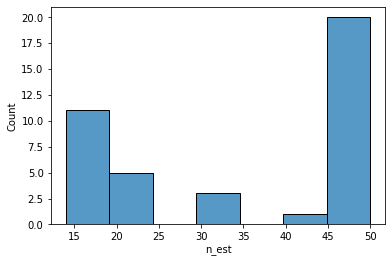

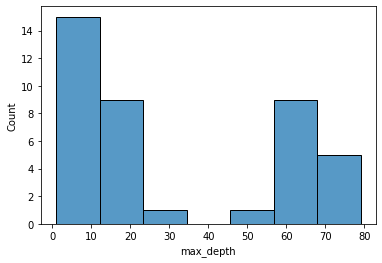

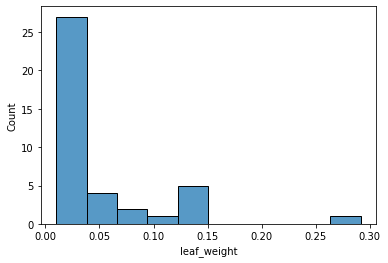

,time,sample,n_est,max_depth,leaf_weight
P63165_nothing_0,15787.606337,21.0,20.0,60.0,0.010000
P04049_with_ala_0,33561.401191,25.0,50.0,7.0,0.010000
P51681_nothing_0,52971.921465,29.0,19.0,71.0,0.010000
Q9BYF1_nothing_0,18049.540202,30.0,15.0,74.0,0.010000
P06654_with_ala_0,25241.101355,34.0,19.0,59.0,0.010000
P35520_nothing_0,73648.099596,36.0,46.0,13.0,0.064543
P40238_with_ala_0,72167.208103,37.0,46.0,4.0,0.010000
P61073_with_ala_0,32048.264086,39.0,49.0,2.0,0.010000
P60484_with_ala_0,72374.566132,40.0,50.0,1.0,0.038639
P63165_with_ala_0,74872.375900,41.0,20.0,25.0,0.010000


In [63]:
foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/06_05_rest/log/')

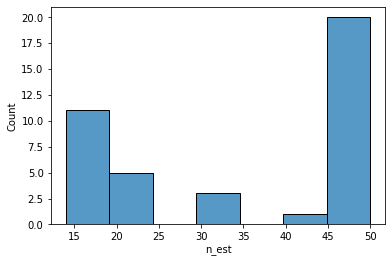

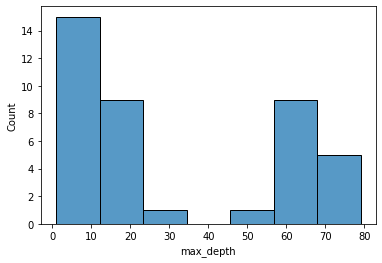

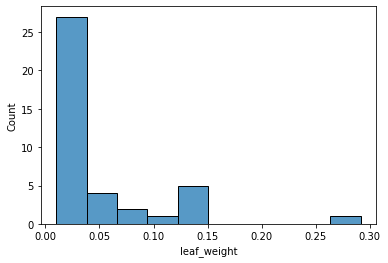

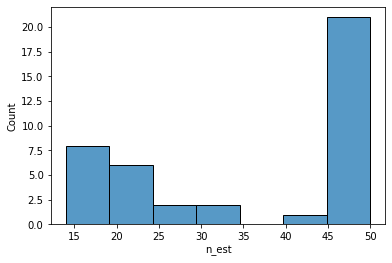

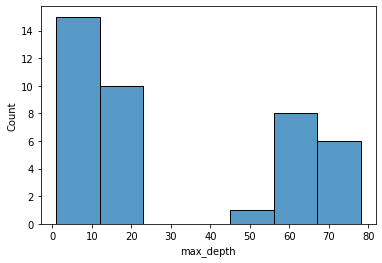

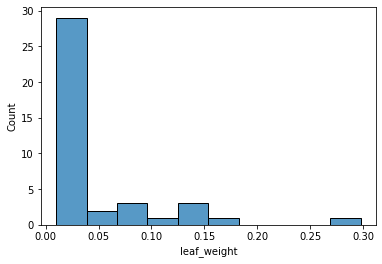

In [291]:
hp_old = foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/06_05_rest/log/')
hp_new = foo_run_hp('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/11_10_structure_08_30_fold_reorder/log/')

pd.options.display.max_rows=100
hp_old['model'] = hp_old.index.str[:9]
hp_new['model'] = hp_new.index.str[:9]

In [313]:
merged = pd.merge(hp_old, hp_new, on='model', how='outer', suffixes=['_old', '_new'])
merged

,time_old,sample_old,n_est_old,max_depth_old,leaf_weight_old,model,time_new,sample_new,n_est_new,max_depth_new,leaf_weight_new
0,15787.606337,21.0,20.0,60.0,0.010000,P63165_no,15460.794506,21.0,20.0,60.0,0.010000
1,33561.401191,25.0,50.0,7.0,0.010000,P04049_wi,25878.854938,25.0,50.0,7.0,0.010000
2,52971.921465,29.0,19.0,71.0,0.010000,P51681_no,15954.709848,18.0,49.0,13.0,0.158433
3,18049.540202,30.0,15.0,74.0,0.010000,Q9BYF1_no,21715.432302,30.0,15.0,74.0,0.010000
4,25241.101355,34.0,19.0,59.0,0.010000,P06654_wi,22411.732641,34.0,19.0,59.0,0.010000
5,73648.099596,36.0,46.0,13.0,0.064543,P35520_no,74267.722064,38.0,46.0,13.0,0.064543
6,72167.208103,37.0,46.0,4.0,0.010000,P40238_wi,72278.931741,42.0,45.0,4.0,0.010000
7,32048.264086,39.0,49.0,2.0,0.010000,P61073_wi,72027.944942,103.0,49.0,3.0,0.016496
8,72374.566132,40.0,50.0,1.0,0.038639,P60484_wi,73799.736077,39.0,50.0,1.0,0.038609
9,74872.375900,41.0,20.0,25.0,0.010000,P63165_wi,72098.716375,31.0,26.0,78.0,0.010000


In [321]:
merged[merged.model.str.split('_').str[1]=='wi'].sort_values('leaf_weight_old')

,time_old,sample_old,n_est_old,max_depth_old,leaf_weight_old,model,time_new,sample_new,n_est_new,max_depth_new,leaf_weight_new
1,33561.401191,25.0,50.0,7.0,0.010000,P04049_wi,25878.854938,25.0,50.0,7.0,0.010000
23,46230.348974,54.0,17.0,59.0,0.010000,Q9GZX7_wi,26441.329008,34.0,20.0,59.0,0.010000
17,72171.948590,47.0,32.0,4.0,0.010000,P38398_wi,72137.612316,42.0,32.0,4.0,0.010000
16,74291.052063,47.0,19.0,62.0,0.010000,P05067_wi,72843.911792,58.0,19.0,62.0,0.010000
14,74550.529744,45.0,24.0,72.0,0.010000,P01112_wi,73178.378094,44.0,24.0,72.0,0.010000
12,26884.572165,43.0,17.0,59.0,0.010000,P04637_wi,17810.675758,34.0,14.0,70.0,0.010000
11,73122.945216,42.0,31.0,6.0,0.010000,P51681_wi,72566.438002,46.0,25.0,11.0,0.010000
13,37209.359953,45.0,47.0,3.0,0.010000,P05412_wi,37239.994253,55.0,47.0,3.0,0.010000
9,74872.375900,41.0,20.0,25.0,0.010000,P63165_wi,72098.716375,31.0,26.0,78.0,0.010000
7,32048.264086,39.0,49.0,2.0,0.010000,P61073_wi,72027.944942,103.0,49.0,3.0,0.016496


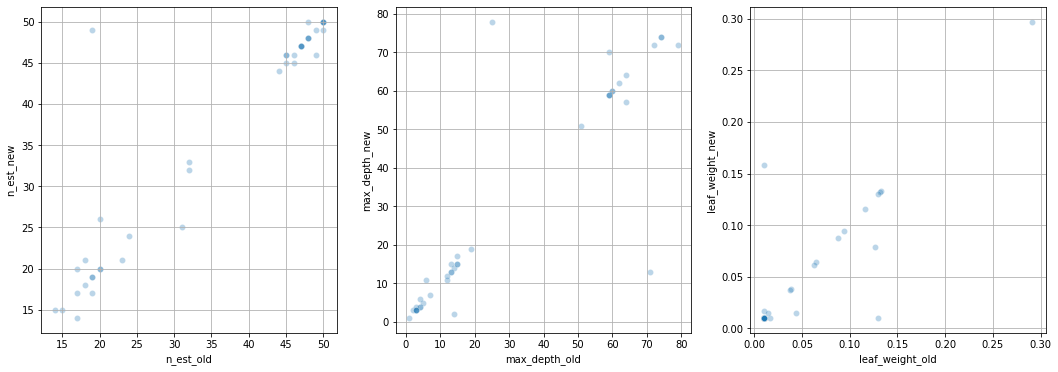

In [318]:
fig, axs = plt.subplots(1,3,figsize=(18,6))
for i, col in enumerate(['n_est', 'max_depth', 'leaf_weight']):
    sns.scatterplot(data=merged, x=f"{col}_old", y=f"{col}_new", ax=axs[i], alpha=0.3)
    axs[i].grid()
plt.show()

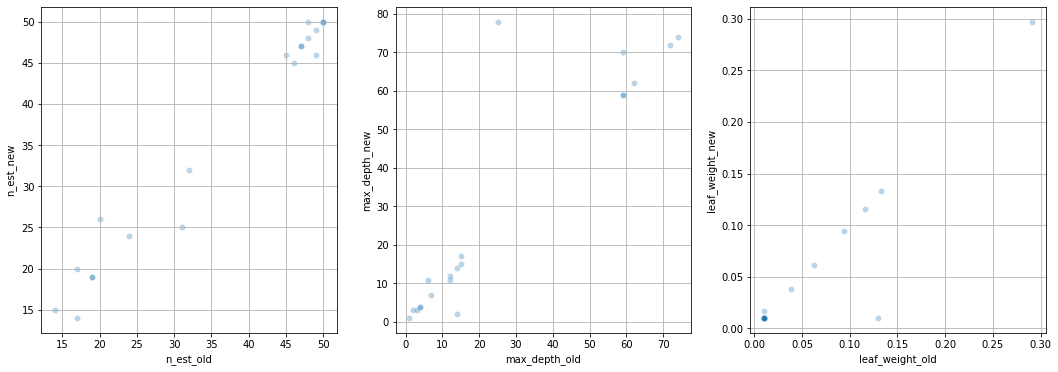

In [319]:
fig, axs = plt.subplots(1,3,figsize=(18,6))
for i, col in enumerate(['n_est', 'max_depth', 'leaf_weight']):
    sns.scatterplot(data=merged[merged.model.str.split('_').str[1]=='wi'], x=f"{col}_old", y=f"{col}_new", ax=axs[i], alpha=0.3)
    axs[i].grid()
plt.show()

## Best result compare

In [ ]:
train_info = ['P38398',0,True,0]
test_unip = train_info[0]
test_rep = train_info[1]
test_with_ala = train_info[2]
seed = int(train_info[3])
wkdir = '/data/gpfs/projects/punim0860/imputation/'


import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.ensemble import GradientBoostingRegressor
sys.path.append(f"{wkdir}project_modules")
import cdma.models as models


prep_data = pd.read_csv(f'{wkdir}data/prep_envfeat_211011+211029+v12.csv', index_col=0)
imp_ascan = pd.read_csv(f"../../05_all_demimp_spartan/data/{test_unip}_mat_AS_prep_dmsa.csv",
                        index_col=0, na_values='', keep_default_na=False).reset_index(drop=True)
dms_ascan = pd.merge(imp_ascan[['dms_id', 'position', 'aa2', 'dmsa_id', 'Ascan_id', 'AS_score', 'Ascan_score_avail']],
                     prep_data, on=['dms_id', 'position', 'aa2'], how='outer', validate='m:1')
dms_ascan['AS_score'] = dms_ascan['AS_score'].fillna(dms_ascan['AS_score'].dropna().mean())
dms_ascan['dmsa_id'] = dms_ascan['dms_id'] + '@' + dms_ascan['Ascan_id'].astype(str)
dms_ascan['Ascan_score_avail'] = ~dms_ascan['Ascan_id'].isna()

with open(f'{wkdir}data/feature_dictionary.txt', 'r') as file:
    feature = eval(file.read())['Envision']
    
# Data preprocessing.
dms_ascan = dms_ascan.reset_index(drop=True)

# Set training weight.
mut_count = dms_ascan[['uniprot_id', 'u_pos', 'aa2', 'score']].groupby(['uniprot_id', 'u_pos', 'aa2'], as_index=False).count()
mut_count['weight'] = 1 / mut_count['score']
mut_count.drop(columns='score', inplace=True)
dms_ascan = pd.merge(dms_ascan, mut_count, on=['uniprot_id', 'u_pos', 'aa2'], how='outer', validate='m:1')

# Separate training and testing data.
train_data = dms_ascan[dms_ascan['uniprot_id'] != test_unip]
test_data = dms_ascan[dms_ascan['uniprot_id'] == test_unip]

# Parameters setting.
search_space = [{'name':'n_estimators', 'type':'discrete', 'domain':np.arange(10, 51), 'dtype':int},
                {'name':'max_depth', 'type':'discrete', 'domain':np.arange(1, 81), 'dtype':int},
                {'name':'min_weight_fraction_leaf', 'type':'continuous', 'domain':(0.01,0.5), 'dtype':float}]
estimator = GradientBoostingRegressor(random_state=seed)

# Parameters preprocessing.
if test_with_ala:
    model_feature = feature+['AS_score']
    model_name = 'with_ala'
else:
    model_feature = feature.copy()
    model_name = 'nothing'
output_header = f"./log/{test_unip}_{model_name}_{test_rep}_"
bo_kwargs = {'num_iterations': 500, 'num_cores': 1, 'if_maximize': True, 'output_header': output_header,
             'random_seed': seed, 'max_time': 72000}
cv_kwargs = {'scoring': 'neg_mean_squared_error', 'cv': GroupKFold(30), 'n_jobs': 6}
cv_kwargs['groups'] = train_data['uniprot_id']
cv_kwargs['fit_params'] = {'sample_weight': train_data['weight']}

dms_ascan.to_csv('./dms_ascan.csv')
train_data.to_csv('./train_data.csv')
test_data.to_csv('./test_data.csv')
with open('./bo.txt', 'w+') as file:
    file.write(bo_kwargs)
with open('./cv.txt', 'w+') as file:
    file.write(cv_kwargs)
with open('./head.txt', 'w+') as file:
    file.write(output_header)

### Data

In [208]:
test_unip = 'P38398'
test_rep = 0
test_with_ala = False
seed = 0

prep_data = pd.read_csv('/Users/fu.j/AnacondaProjects/Project_3_extrapolation_model/data/dmsa_data/211029/prep_envfeat_211011+211029+v12.csv', index_col=0)
imp_ascan = pd.read_csv(f"/Users/fu.j/Desktop/temp_imp/{test_unip}_mat_AS_prep_dmsa.csv",
                        index_col=0, na_values='', keep_default_na=False).reset_index(drop=True)
dms_ascan = pd.merge(imp_ascan[['dms_id', 'position', 'aa2', 'dmsa_id', 'Ascan_id', 'AS_score', 'Ascan_score_avail']],
                     prep_data, on=['dms_id', 'position', 'aa2'], how='outer', validate='m:1')
dms_ascan['AS_score'] = dms_ascan['AS_score'].fillna(dms_ascan['AS_score'].dropna().mean())
dms_ascan['dmsa_id'] = dms_ascan['dms_id'] + '@' + dms_ascan['Ascan_id'].astype(str)
dms_ascan['Ascan_score_avail'] = ~dms_ascan['Ascan_id'].isna()

with open(f'/Users/fu.j/AnacondaProjects/Project_2_Enlarged_data/Data_with_feature/feature_dictionary.txt', 'r') as file:
    feature = eval(file.read())['Envision']
    
# Data preprocessing.
dms_ascan = dms_ascan.reset_index(drop=True)

# Set training weight.
mut_count = dms_ascan[['uniprot_id', 'u_pos', 'aa2', 'score']].groupby(['uniprot_id', 'u_pos', 'aa2'], as_index=False).count()
mut_count['weight'] = 1 / mut_count['score']
mut_count.drop(columns='score', inplace=True)
dms_ascan = pd.merge(dms_ascan, mut_count, on=['uniprot_id', 'u_pos', 'aa2'], how='outer', validate='m:1')

# Separate training and testing data.
old_train_data = dms_ascan[dms_ascan['uniprot_id'] != test_unip]
old_test_data = dms_ascan[dms_ascan['uniprot_id'] == test_unip]

# Parameters setting.
old_search_space = [{'name':'n_estimators', 'type':'discrete', 'domain':np.arange(10, 51), 'dtype':int},
                {'name':'max_depth', 'type':'discrete', 'domain':np.arange(1, 81), 'dtype':int},
                {'name':'min_weight_fraction_leaf', 'type':'continuous', 'domain':(0.01,0.5), 'dtype':float}]
old_estimator = GradientBoostingRegressor(random_state=seed)

# Parameters preprocessing.
if test_with_ala:
    model_feature = feature+['AS_score']
    model_name = 'with_ala'
else:
    model_feature = feature.copy()
    model_name = 'nothing'
output_header = f"./log/{test_unip}_{model_name}_{test_rep}_"
old_bo_kwargs = {'num_iterations': 500, 'num_cores': 1, 'if_maximize': True, 'output_header': output_header,
             'random_seed': seed, 'max_time': 72000}
old_cv_kwargs = {'scoring': 'neg_mean_squared_error', 'cv': GroupKFold(30), 'n_jobs': 6}
old_cv_kwargs['groups'] = old_train_data['uniprot_id']
old_cv_kwargs['fit_params'] = {'sample_weight': old_train_data['weight']}

In [136]:
spartan_old = pd.read_csv('~/Desktop/temp/dms_ascan.csv', index_col=0)
pd.testing.assert_frame_equal(spartan_old,dms_ascan)

In [137]:
spartan_train = pd.read_csv('/Users/fu.j/Desktop/temp/train_data.csv', index_col=0)
pd.testing.assert_frame_equal(spartan_train, old_train_data)

In [138]:
spartan_test = pd.read_csv('/Users/fu.j/Desktop/temp/test_data.csv', index_col=0)
pd.testing.assert_frame_equal(spartan_test, old_test_data)

In [43]:
unip = 'P38398'
test_with_ala = True
model = {True: 'with_as', False: 'no_as'}[test_with_ala]
seed = 0


def add_training_weight(input_data):
    weight = input_data.groupby(['uniprot_id', 'u_pos', 'aa2'])['score'].count()
    weight = 1 / weight
    weight.name = 'weight'
    weighted_data = pd.merge(input_data, weight, left_on=['uniprot_id', 'u_pos', 'aa2'], right_index=True,
                             how='outer', validate='m:1').reset_index(drop=True)
    return weighted_data


DEMASK_FEATURES = ['entropy', 'log2f_var', 'matrix']


data_info = pd.read_csv(f'../data/data_info/dataset_info.csv', index_col=0)
norm_as = pd.read_csv(f'../data/normalized/normalized_alanine_scanning.csv')

# Pick AS subset that are highly compatibility with given DMS assay.
comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')

# Preprocess data: impute missing values and encode categorical features.
norm_dms_env = pd.read_csv(f'../data/normalized/normalized_dms_Envision_features.csv', 
                           index_col=0, na_values=[''], keep_default_na=False)
# Pick DMS data whose target protein has AS data available.
norm_dms_env = norm_dms_env[norm_dms_env.uniprot_id.isin(norm_as.uniprot_id.unique())]
features = ['aa1', 'aa2', 'wt_mut', 'aa1_polarity', 'aa2_polarity', 'aa1_PI','aa2_PI', 'deltaPI', 
            'Grantham', 'aa1_weight', 'aa2_weight', 'deltaWeight', 'aa1vol', 'aa2vol', 'deltavolume',
            'aa1_psic', 'aa2_psic', 'delta_psic', 'accessibility', 'dssp_sec_str', 'phi_psi_reg',
            'delta_solvent_accessibility', 'b_factor', 'mut_msa_congruency', 'seq_ind_closest_mut', 
            'mut_mut_msa_congruency', 'evolutionary_coupling_avg']
categ_feat = ['aa1', 'aa2', 'wt_mut', 'aa1_polarity', 'aa2_polarity', 'dssp_sec_str', 'phi_psi_reg']
numer_feat = [x for x in features if x not in categ_feat]
norm_dms_env = preproc.impute_missing_value(norm_dms_env, categ_feat, numer_feat)
norm_dms_env, encoded_col = preproc.encode_categorical_feature(norm_dms_env, categ_feat, ['aa1', 'aa2'])
envision_features = encoded_col + numer_feat

# Merge AS data and DMS data with Envision feature.
dmsas_env = pd.merge(norm_dms_env, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                     on=['dms_id', 'u_pos'], how='left')
dmsas_env['dmsa_id'] = dmsas_env['dms_id'] + '@' + dmsas_env['Ascan_id'].astype(str)
dmsas_env['Ascan_score_avail'] = ~dmsas_env['AS_score'].isna()
dmsas_env = preproc.impute_missing_value(dmsas_env, None, ['AS_score'])
dmsas_env = add_training_weight(dmsas_env)
dmsas_env = dmsas_env[dmsas_env['Ascan_score_avail']]

In [82]:
len(dmsas_env[dmsas_env['Ascan_score_avail']].uniprot_id.unique())

14

In [47]:
dmsas_env.dmsa_id.unique()

array(['urn:mavedb:00000047-a-1@nan', 'ccr5-2d7-bind@nan',
       'ccr5-gp120cd4-bind@nan', 'urn:mavedb:00000047-a-1@ccr5_nave_227r',
       'ccr5-2d7-bind@ccr5_nave_227r',
       'ccr5-gp120cd4-bind@ccr5_dragic_ada',
       'ccr5-gp120cd4-bind@ccr5_dragic_dh123',
       'ccr5-gp120cd4-bind@ccr5_dragic_jrfl',
       'ccr5-gp120cd4-bind@ccr5_dragic_mip1a',
       'urn:mavedb:00000047-a-1@ccr5_tan_exp',
       'ccr5-2d7-bind@ccr5_tan_exp', 'ccr5-gp120cd4-bind@ccr5_tan_jrfl',
       'ccr5-gp120cd4-bind@ccr5_tan_sf162',
       'urn:mavedb:00000047-a-1@ccr5_blanpain_exp',
       'ccr5-2d7-bind@ccr5_blanpain_exp',
       'ccr5-gp120cd4-bind@ccr5_blanpain_jrfl',
       'urn:mavedb:00000047-a-1@ccr5_rabut_exp',
       'ccr5-2d7-bind@ccr5_rabut_exp',
       'ccr5-gp120cd4-bind@ccr5_rabut_ada',
       'ccr5-gp120cd4-bind@ccr5_rabut_dh123',
       'ccr5-gp120cd4-bind@ccr5_rabut_gun1',
       'ccr5-gp120cd4-bind@ccr5_rabut_jrfl',
       'urn:mavedb:00000047-a-1@ccr5_nave_2d7',
       'ccr5-2d7-bin

In [56]:
dmsas_dem.query("dmsa_id=='gcn4-starvation@gcn4_arg3'")[['dms_id', 'position', 'aa2', 'score', 
                                                                    'AS_score', 'Ascan_score_avail']].sort_values(['position', 'aa2'])

,dms_id,position,aa2,score,AS_score,Ascan_score_avail
72386,gcn4-starvation,20.0,A,0.596027,0.309680,True
72390,gcn4-starvation,20.0,L,1.034614,0.309680,True
72400,gcn4-starvation,23.0,A,0.834543,0.670340,True
72404,gcn4-starvation,23.0,W,0.673066,0.670340,True
72408,gcn4-starvation,24.0,A,0.763888,0.397102,True
72412,gcn4-starvation,24.0,I,0.976848,0.397102,True
72416,gcn4-starvation,24.0,W,0.743382,0.397102,True


In [68]:
as_id = comp_as_id['Ascan_id'].unique()
cols = ['dms_id', 'dmsa_id', 'position', 'aa2', 'score', 'Ascan_id', 'AS_score', 'Ascan_score_avail']
left = dmsas_env.query("Ascan_id in @as_id")[cols].sort_values(['dmsa_id', 'position', 'aa2', 'AS_score']).reset_index(drop=True)
right = dmsas_dem.query("Ascan_id in @as_id")[cols].sort_values(['dmsa_id', 'position', 'aa2', 'AS_score']).reset_index(drop=True)

In [70]:
pd.testing.assert_frame_equal(left, right)

In [71]:
right

,dms_id,dmsa_id,position,aa2,score,Ascan_id,AS_score,Ascan_score_avail
0,Brca1_E3,Brca1_E3@brca1_mono_ub,26.0,A,0.747224,brca1_mono_ub,0.097819,True
1,Brca1_E3,Brca1_E3@brca1_mono_ub,26.0,C,0.704544,brca1_mono_ub,0.097819,True
2,Brca1_E3,Brca1_E3@brca1_mono_ub,26.0,D,0.725479,brca1_mono_ub,0.097819,True
3,Brca1_E3,Brca1_E3@brca1_mono_ub,26.0,E,0.639589,brca1_mono_ub,0.097819,True
4,Brca1_E3,Brca1_E3@brca1_mono_ub,26.0,F,0.747730,brca1_mono_ub,0.097819,True
...,...,...,...,...,...,...,...,...
17357,urn:mavedb:00000054-a-1,urn:mavedb:00000054-a-1@pten,171.0,S,0.389594,pten,0.087642,True
17358,urn:mavedb:00000054-a-1,urn:mavedb:00000054-a-1@pten,171.0,T,0.173414,pten,0.087642,True
17359,urn:mavedb:00000054-a-1,urn:mavedb:00000054-a-1@pten,171.0,V,0.099300,pten,0.087642,True
17360,urn:mavedb:00000054-a-1,urn:mavedb:00000054-a-1@pten,171.0,W,0.201341,pten,0.087642,True


In [57]:
dmsas_env.query("dmsa_id=='gcn4-starvation@gcn4_arg3'").sort_values(['position', 'aa2'])

,dms_id,position,aa2,score,AS_score,Ascan_score_avail
61787,gcn4-starvation,20.0,A,0.596027,0.309680,True
61791,gcn4-starvation,20.0,L,1.034614,0.309680,True
61801,gcn4-starvation,23.0,A,0.834543,0.670340,True
61805,gcn4-starvation,23.0,W,0.673066,0.670340,True
61809,gcn4-starvation,24.0,A,0.763888,0.397102,True
61813,gcn4-starvation,24.0,I,0.976848,0.397102,True
61817,gcn4-starvation,24.0,W,0.743382,0.397102,True


In [25]:
unip = 'P38398'
test_with_ala = True
model = {True: 'with_as', False: 'no_as'}[test_with_ala]
seed = 0


def add_training_weight(input_data):
    weight = input_data.groupby(['uniprot_id', 'u_pos', 'aa2'])['score'].count()
    weight = 1 / weight
    weight.name = 'weight'
    weighted_data = pd.merge(input_data, weight, left_on=['uniprot_id', 'u_pos', 'aa2'], right_index=True,
                             how='outer', validate='m:1').reset_index(drop=True)
    return weighted_data


DEMASK_FEATURES = ['entropy', 'log2f_var', 'matrix']


data_info = pd.read_csv(f'../data/data_info/dataset_info.csv', index_col=0)
norm_as = pd.read_csv(f'../data/normalized/normalized_alanine_scanning.csv')

# Pick AS subset that are highly compatibility with given DMS assay.
comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')

# Preprocess data: impute missing values and encode categorical features.
norm_dms_env = pd.read_csv(f'../data/normalized/normalized_dms_Envision_features.csv', 
                           index_col=0, na_values=[''], keep_default_na=False)
features = ['aa1', 'aa2', 'wt_mut', 'aa1_polarity', 'aa2_polarity', 'aa1_PI','aa2_PI', 'deltaPI', 
            'Grantham', 'aa1_weight', 'aa2_weight', 'deltaWeight', 'aa1vol', 'aa2vol', 'deltavolume',
            'aa1_psic', 'aa2_psic', 'delta_psic', 'accessibility', 'dssp_sec_str', 'phi_psi_reg',
            'delta_solvent_accessibility', 'b_factor', 'mut_msa_congruency', 'seq_ind_closest_mut', 
            'mut_mut_msa_congruency', 'evolutionary_coupling_avg']
categ_feat = ['aa1', 'aa2', 'wt_mut', 'aa1_polarity', 'aa2_polarity', 'dssp_sec_str', 'phi_psi_reg']
numer_feat = [x for x in features if x not in categ_feat]
norm_dms_env = preproc.impute_missing_value(norm_dms_env, categ_feat, numer_feat)
norm_dms_env, encoded_col = preproc.encode_categorical_feature(norm_dms_env, categ_feat, ['aa1', 'aa2'])
envision_features = encoded_col + numer_feat

# Prepare DMS+AS data with Envision feature.
dmsas_env = pd.merge(norm_dms_env, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                     on=['dms_id', 'u_pos'], how='left')
dmsas_env['dmsa_id'] = dmsas_env['dms_id'] + '@' + dmsas_env['Ascan_id'].astype(str)
dmsas_env['Ascan_score_avail'] = ~dmsas_env['AS_score'].isna()
dmsas_env = preproc.impute_missing_value(dmsas_env, None, ['AS_score'])
dmsas_env = add_training_weight(dmsas_env)

# Set parameters.
output_dir = './log/'
search_space = [{'name':'n_estimators', 'type':'discrete', 'domain':np.arange(10, 51), 'dtype':int},
                {'name':'max_depth', 'type':'discrete', 'domain':np.arange(1, 81), 'dtype':int},
                {'name':'min_weight_fraction_leaf', 'type':'continuous', 'domain':(0.01,0.5), 'dtype':float}]
bo_kwargs = {'num_iterations': 500, 'num_cores': 1, 'if_maximize': True, 'random_seed': seed, 'max_time': 72000}
cv_kwargs = {'scoring': 'neg_mean_squared_error', 'cv': GroupKFold(30), 'n_jobs': 6}

# LOPO
train_data = dmsas_env.query("uniprot_id != @unip")
test_data_ori = dmsas_env.query("uniprot_id == @unip")
cv_kwargs['fit_params'] = {'sample_weight': train_data['weight']}
cv_kwargs['groups'] = train_data['uniprot_id']

# Set model.
if model == 'with_as':
    model_features = envision_features + ['AS_score', 'Ascan_score_avail']
else:
    model_features = envision_features.copy()
output_header = f"{output_dir}{unip}_{model}_"
bo_kwargs['output_header'] = output_header

In [210]:
old = dms_ascan.sort_values(['dmsa_id', 'position', 'aa2']).reset_index(drop=True)
new = dmsas_env.sort_values(['dmsa_id', 'position', 'aa2'])[dms_ascan.columns].reset_index(drop=True)
print(all(np.sort(old.columns) == np.sort(new.columns)))
pd.testing.assert_frame_equal(old, new)

True


In [211]:
old = old_test_data.sort_values(['dmsa_id', 'position', 'aa2']).reset_index(drop=True)
new = test_data_ori.sort_values(['dmsa_id', 'position', 'aa2'])[dms_ascan.columns].reset_index(drop=True)
print(all(np.sort(old.columns) == np.sort(new.columns)))
pd.testing.assert_frame_equal(old, new)

True


In [212]:
old = old_train_data.sort_values(['dmsa_id', 'position', 'aa2']).reset_index(drop=True)
new = train_data.sort_values(['dmsa_id', 'position', 'aa2'])[dms_ascan.columns].reset_index(drop=True)
print(all(np.sort(old.columns) == np.sort(new.columns)))
pd.testing.assert_frame_equal(old, new)

True


In [213]:
all(np.sort(model_feature)==np.sort(model_features))

True

### Model

In [214]:
old = pd.read_csv('/Users/fu.j/Desktop/temp/log/P38398_nothing_0_test_prediction.csv', index_col=0)
old = old.query("dmsa_id=='Brca1_E3@brca1_mono_ub'")
ana.spearmanr(old['ob_score'], old['pred_score'])[0]

0.3465306436525495

In [215]:
new = pd.read_csv('/Users/fu.j/Desktop/temp2/log/P38398_no_as_prediction.csv', index_col=0)
new = new.query("dmsa_id=='Brca1_E3@brca1_mono_ub'")
ana.spearmanr(new['score'], new['pred_score'])[0]

0.3465306436525495

In [238]:
with open('/Users/fu.j/Desktop/temp/models.pickle', 'rb') as file:
    old = pickle.load(file)
old

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.01,
             n_estimators=44, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [235]:
np.sort(old.feature_importances_)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [223]:
old.predict(old_test_data[model_feature])

array([0.78379877, 0.78379877, 0.78379877, ..., 0.75325592, 0.83901541,
       0.70354776])

In [239]:
with open('/Users/fu.j/Desktop/temp2/models.pickle', 'rb') as file:
    new = pickle.load(file)
new

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.01,
             n_estimators=44, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [236]:
np.sort(new.feature_importances_)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [227]:
new.predict(test_data_ori[model_features])

array([0.7655684 , 0.65116489, 0.83502523, ..., 0.83901541, 0.70354776,
       0.75325592])

In [251]:
def save_compared_prediction(
    predictor,
    mut_data,
    features,
    y_col_name,
    output_header,
    if_train=False,
    info_col=["dms_id", "position", "aa2"],
):
    # Index of observed scores are maintained for concatenation.
    result = mut_data[y_col_name].to_frame(name="ob_score")
    result["pred_score"] = predictor.predict(mut_data[features])
    result["if_train"] = if_train
    mut_info = mut_data[info_col]
    mut_pred = pd.concat([mut_info, result], axis=1, sort=False)
    return mut_pred


iwt_test = save_compared_prediction(old, old_test_data, model_feature, 'score', None, 
                                    info_col=["dmsa_id", "position", "aa2"])
iwt_test = iwt_test.query("dmsa_id=='Brca1_E3@brca1_mono_ub'")
ana.spearmanr(iwt_test['ob_score'], iwt_test['pred_score'])[0]

0.3465306436525495

In [246]:
wtf_test = test_data_ori.copy()
wtf_test['pred_score'] = new.predict(wtf_test[model_features])
wtf_test = wtf_test[["dmsa_id", "position", "aa2", "score", "pred_score"]]

wtf_test = wtf_test.query("dmsa_id=='Brca1_E3@brca1_mono_ub'")
ana.spearmanr(wtf_test['score'], wtf_test['pred_score'])[0]

0.3465306436525495

In [ ]:
predictor = models.fit_best_estimator(search_space, estimator, train_data[model_feature], train_data['score'],
                                      cv_kwargs, bo_kwargs)
models.save_feature_importance(predictor, output_header)
models.save_tuned_hyperparameters(predictor, search_space, output_header)
models.save_compared_prediction(predictor, test_data, model_feature, 'score', output_header+'test_', info_col=["dmsa_id", "position", "aa2"])

#######################
predictor = tune.fit_best_estimator(search_space, estimator, train_data[model_features], 
                                      train_data['score'], cv_kwargs, bo_kwargs)
test_data = test_data_ori.copy()
test_data['pred_score'] = predictor.predict(test_data[model_features])

# Saving results.
test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")

### Result

In [82]:
def foo_read(result_dir, target_proteins, models=['with_as', 'no_as'], score_col='score'):
    """Read leave-one-protein-out cross-validation results for using AS data or not.
    """
    results = dict()
    for model in models:
        results[model] = pd.concat([pd.read_csv(f"{result_dir}{unip}_{model}_prediction.csv", index_col=0) 
                                    for unip in target_proteins])
        if score_col != 'score':
            results[model] = results[model].rename(columns={score_col: 'score'})
    pred_merge = pd.merge(results[models[0]], results[models[1]], on=["dmsa_id", "position", "aa2", "score"],
                          validate="1:1", suffixes=["_ala", "_noala"], how='outer')
    return pred_merge

In [80]:
def foo_eval(results):
    model_perform = []
    for model, pred_result in results.items():
        perf_with_as = ana.subgroup_spearmanr(pred_result, 'dmsa_id', 'score', 'pred_score_ala')
        perf_no_as = ana.subgroup_spearmanr(pred_result, 'dmsa_id', 'score', 'pred_score_noala')
        perf_merge = pd.merge(perf_with_as, perf_no_as[['rho']], left_index=True, right_index=True, validate="1:1", 
                              suffixes=["_ala", "_noala"], how='outer')
        perf_merge['model'] = model
        model_perform.append(perf_merge)
    model_perform = pd.concat(model_perform)
    model_perform.rename(columns={'rho_ala': 'With AS', 'rho_noala': 'No AS'}, inplace=True)
    model_perform['diff_spear'] = model_perform['With AS'] - model_perform['No AS']
    model_perform = pd.merge(model_perform, data_info, left_index=True, right_on='dmsa_id', how='left', validate='m:1')
    return model_perform

In [252]:
old_pred = foo_read('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/06_05_rest/log/',
                    dmsas_env[dmsas_env['Ascan_score_avail']].uniprot_id.unique(), ['with_ala_0_test', 'nothing_0_test'],
                    'ob_score')
new_pred = foo_read('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/11_10_structure_08_30_fold_reorder/log/',
                    dmsas_env[dmsas_env['Ascan_score_avail']].uniprot_id.unique())
model_perform = foo_eval({'old': old_pred, 'new': new_pred})

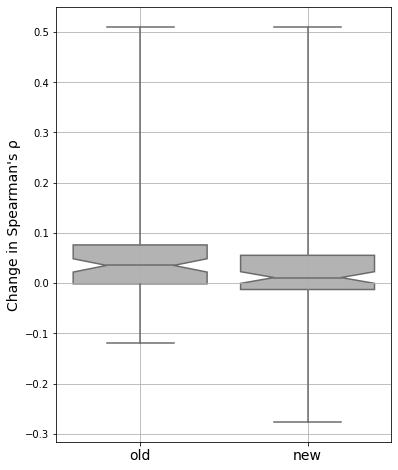

In [253]:
vis_data = model_perform[~model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")
fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=0)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

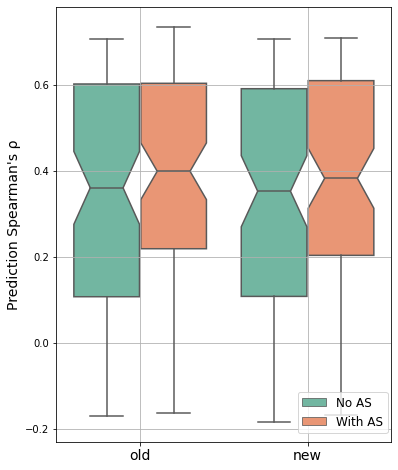

In [254]:
vis_data = model_perform[~model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")
vis_data = vis_data.melt(id_vars=['dmsa_id', 'model', 'size'], value_vars=['No AS', 'With AS'], value_name='spear', 
                         var_name='Feature')

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='spear', hue='Feature', palette='Set2', notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_ylabel('Prediction Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.legend(loc=[0.72,0.02], fontsize=12)
ax.grid()
plt.show()

In [255]:
vis_data = model_perform[~model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")
vis_data = vis_data.melt(id_vars=['dmsa_id', 'model', 'size'], value_vars=['No AS', 'With AS'], value_name='spear', 
                         var_name='Feature')
vis_data['joint_id'] = vis_data['dmsa_id'] + '@jid@' + vis_data['Feature']
vis_data = vis_data.pivot(index='joint_id', columns='model', values='spear')
vis_data['dmsa_id'] =vis_data.index.str.split('@jid@').str[0]
vis_data['Feature'] =vis_data.index.str.split('@jid@').str[1]

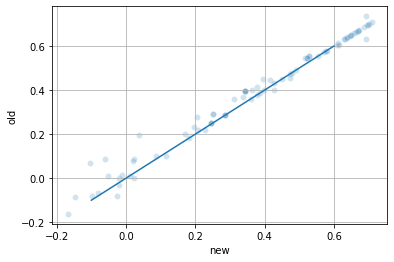

In [256]:
sns.scatterplot(data=vis_data.query("Feature == 'With AS'"), x='new', y='old', alpha=0.2)
plt.plot([-0.1,0.6],[-0.1,0.6])
plt.grid()
plt.show()

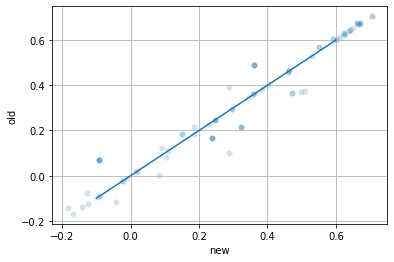

In [258]:
sns.scatterplot(data=vis_data.query("Feature == 'No AS'"), x='new', y='old', alpha=0.2)
plt.plot([-0.1,0.6],[-0.1,0.6])
plt.grid()
plt.show()

In [148]:
old_pred.query("dmsa_id=='Brca1_E3@brca1_mono_ub'").sort_values(['dmsa_id', 'position', 'aa2'])

,dmsa_id,position,aa2,score,pred_score_ala,if_train_ala,pred_score_noala,if_train_noala
51073,Brca1_E3@brca1_mono_ub,26.0,A,0.747224,0.566517,False,0.598957,False
51078,Brca1_E3@brca1_mono_ub,26.0,C,0.704544,0.574636,False,0.640796,False
51083,Brca1_E3@brca1_mono_ub,26.0,D,0.725479,0.502976,False,0.484950,False
51088,Brca1_E3@brca1_mono_ub,26.0,E,0.639589,0.502976,False,0.490532,False
51093,Brca1_E3@brca1_mono_ub,26.0,F,0.747730,0.571036,False,0.666270,False
...,...,...,...,...,...,...,...,...
54614,Brca1_E3@brca1_mono_ub,65.0,S,0.823019,0.552982,False,0.611081,False
54619,Brca1_E3@brca1_mono_ub,65.0,T,0.531396,0.537591,False,0.620891,False
54625,Brca1_E3@brca1_mono_ub,65.0,V,0.722932,0.530842,False,0.584605,False
54630,Brca1_E3@brca1_mono_ub,65.0,W,0.638154,0.523150,False,0.550459,False


In [150]:
pd.read_csv('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/06_05_rest/log/P38398_nothing_0_tuned_result.csv')

,Unnamed: 0,n_estimators,max_depth,min_weight_fraction_leaf
0,0,44,5,0.01


In [151]:
pd.read_csv('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/11_10_structure_08_30_fold_reorder/log/P38398_no_as_tuned_result.csv')

,Unnamed: 0,n_estimators,max_depth,min_weight_fraction_leaf
0,0,44,5,0.01


In [176]:
import pickle
with open('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/06_05_rest/log/P38398_nothing_0_feature_param.pickle', 'rb') as file:
    imp = pickle.load(file)
    
imp = pd.Series(dict(zip(model_feature, imp)))
imp.sort_values().tail(50)

wt_mut_GD                      0.000000
wt_mut_GC                      0.000000
wt_mut_GA                      0.000000
wt_mut_GI                      0.000000
wt_mut_GY                      0.000000
aa2_S                          0.000114
aa1_V                          0.000248
deltaPI                        0.000305
phi_psi_reg_B                  0.000346
aa2_polarity_Special           0.000525
aa2_M                          0.000575
aa1_K                          0.000595
phi_psi_reg_A                  0.000651
aa2_R                          0.000732
delta_solvent_accessibility    0.001166
aa1_polarity_negativeCharge    0.001383
aa2_polarity_Polar             0.001824
aa1vol                         0.001835
dssp_sec_str_.                 0.002123
aa1_C                          0.002955
aa2vol                         0.003022
aa2_PI                         0.003748
aa2_K                          0.003877
deltavolume                    0.003898
aa1_I                          0.003902


In [177]:
import pickle
with open('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/11_10_structure_08_30_fold_reorder/log/P38398_no_as_feature_param.pickle', 'rb') as file:
    imp = pickle.load(file)
imp = pd.Series(dict(zip(model_features, imp)))
imp.sort_values().tail(50)

wt_mut_GN                      0.000000
wt_mut_GM                      0.000000
wt_mut_GH                      0.000000
wt_mut_GL                      0.000000
wt_mut_GI                      0.000000
wt_mut_GK                      0.000000
aa2_S                          0.000114
aa1_V                          0.000248
deltaPI                        0.000305
phi_psi_reg_B                  0.000346
aa2_polarity_Special           0.000525
aa2_M                          0.000575
phi_psi_reg_A                  0.000651
aa2_R                          0.000732
delta_solvent_accessibility    0.001166
aa1_polarity_negativeCharge    0.001383
aa2_polarity_Polar             0.001824
dssp_sec_str_.                 0.002123
aa1vol                         0.002199
aa2vol                         0.002779
aa1_C                          0.002955
aa2_PI                         0.003748
aa2_K                          0.003877
deltavolume                    0.003898
aa1_I                          0.003902


In [41]:
import os
import pickle


imp = []
root = '/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/19_18_10_fold/log/'
for file_name in os.listdir(root):
    if (file_name[7:9] == 'no') | (file_name[-12:] != 'param.pickle'):
        continue
    with open(f"{root}{file_name}", 'rb') as file:
        imp.append(pd.Series(dict(zip(model_features, pickle.load(file)))))
pd.concat(imp, axis=1).mean(axis=1).sort_values().tail(50)

wt_mut_EY                   0.000000
wt_mut_EW                   0.000000
wt_mut_GF                   0.000000
wt_mut_GH                   0.000000
wt_mut_FY                   0.000000
wt_mut_HI                   0.000000
wt_mut_HQ                   0.000000
wt_mut_HP                   0.000000
wt_mut_HN                   0.000000
wt_mut_HM                   0.000000
wt_mut_HL                   0.000000
wt_mut_HK                   0.000000
wt_mut_GI                   0.000000
wt_mut_HG                   0.000000
wt_mut_HF                   0.000000
wt_mut_HE                   0.000000
wt_mut_HD                   0.000000
wt_mut_HC                   0.000000
wt_mut_HA                   0.000000
wt_mut_GY                   0.000000
AS_score                    0.000000
wt_mut_GV                   0.000000
wt_mut_GM                   0.000000
wt_mut_GW                   0.000000
wt_mut_GN                   0.000000
wt_mut_GL                   0.000000
wt_mut_GP                   0.000000
w

In [20]:
import os
import pickle


imp = []
root = '/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/18_16_avail_feat/log/'
for file_name in os.listdir(root):
    if (file_name[7:9] == 'no') | (file_name[-12:] != 'param.pickle'):
        continue
    with open(f"{root}{file_name}", 'rb') as file:
        imp.append(pd.Series(dict(zip(model_features, pickle.load(file)))))
pd.concat(imp, axis=1).mean(axis=1).sort_values().tail(50)

wt_mut_FD                   0.000000
wt_mut_FC                   0.000000
wt_mut_FA                   0.000000
wt_mut_EY                   0.000000
wt_mut_GH                   0.000000
wt_mut_GI                   0.000000
wt_mut_GA                   0.000000
AS_score                    0.000000
wt_mut_HN                   0.000000
wt_mut_HP                   0.000000
wt_mut_HQ                   0.000000
wt_mut_GK                   0.000000
wt_mut_HK                   0.000000
wt_mut_HI                   0.000000
wt_mut_HG                   0.000000
wt_mut_HF                   0.000000
wt_mut_HE                   0.000000
wt_mut_HD                   0.000000
wt_mut_HL                   0.000000
wt_mut_HA                   0.000000
wt_mut_HC                   0.000000
wt_mut_GW                   0.000000
wt_mut_GV                   0.000000
wt_mut_GT                   0.000000
wt_mut_GS                   0.000000
wt_mut_GR                   0.000000
wt_mut_GQ                   0.000000
w

In [39]:
import os


imp = []
root = '/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/15_avail_comp/log/'
for file_name in os.listdir(root):
    if (file_name[7:9] == 'no') | (file_name[-12:] != 'param.pickle'):
        continue
    with open(f"{root}{file_name}", 'rb') as file:
        imp.append(pd.Series(dict(zip(model_features, pickle.load(file)))))
pd.concat(imp, axis=1).mean(axis=1).sort_values().tail(50)

dssp_sec_str_T                 0.000055
aa2_S                          0.000063
phi_psi_reg_B                  0.000073
aa1_M                          0.000097
aa2_polarity_PositiveCharge    0.000126
aa2_polarity_Special           0.000218
aa2_R                          0.000295
aa1_polarity_negativeCharge    0.000347
aa1_S                          0.000372
aa1_K                          0.000421
aa2_H                          0.000652
aa2_polarity_Polar             0.000919
Ascan_score_avail              0.001017
aa1_I                          0.001019
dssp_sec_str_.                 0.001171
phi_psi_reg_A                  0.001528
aa2_K                          0.001641
deltaPI                        0.001891
delta_solvent_accessibility    0.001920
aa1_polarity_Special           0.002196
deltaWeight                    0.002272
aa1vol                         0.002654
aa1_polarity_Polar             0.002696
aa1_C                          0.003507
aa1_PI                         0.003738


In [40]:
import os


imp = []
root = '/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/16_limit_comp/log/'
for file_name in os.listdir(root):
    if (file_name[7:9] == 'no') | (file_name[-12:] != 'param.pickle'):
        continue
    with open(f"{root}{file_name}", 'rb') as file:
        imp.append(pd.Series(dict(zip(model_features, pickle.load(file)))))
pd.concat(imp, axis=1).mean(axis=1).sort_values().tail(50)

wt_mut_HM                      0.000000
wt_mut_HL                      0.000000
wt_mut_HK                      0.000000
wt_mut_HI                      0.000000
wt_mut_HG                      0.000000
wt_mut_HF                      0.000000
wt_mut_HE                      0.000000
wt_mut_HD                      0.000000
wt_mut_HC                      0.000000
wt_mut_HA                      0.000000
wt_mut_GK                      0.000000
wt_mut_GY                      0.000000
wt_mut_GV                      0.000000
wt_mut_GT                      0.000000
wt_mut_GS                      0.000000
wt_mut_GR                      0.000000
wt_mut_GQ                      0.000000
wt_mut_GP                      0.000000
wt_mut_GN                      0.000000
wt_mut_GM                      0.000000
wt_mut_GL                      0.000000
wt_mut_GW                      0.000000
wt_mut_FE                      0.000000
aa1vol                         0.000082
aa1_polarity_Special           0.000128


In [16]:
import pickle
with open('/Users/fu.j/Documents/Spartan_Process/007_extrapolation/13_sel_env/13_09_improve/15_avail_comp/log/P38398_no_as_feature_param.pickle', 'rb') as file:
    imp = pickle.load(file)
imp = pd.Series(dict(zip(model_features, imp)))
imp.sort_values().tail(50)

wt_mut_HA                      0.000000
wt_mut_GY                      0.000000
wt_mut_GH                      0.000000
wt_mut_FI                      0.000000
wt_mut_GT                      0.000000
wt_mut_GS                      0.000000
wt_mut_GR                      0.000000
wt_mut_GQ                      0.000000
wt_mut_GP                      0.000000
wt_mut_GN                      0.000000
wt_mut_GM                      0.000000
wt_mut_GL                      0.000000
wt_mut_GK                      0.000000
wt_mut_GI                      0.000000
wt_mut_GV                      0.000000
deltaWeight                    0.000280
deltaPI                        0.000872
dssp_sec_str_.                 0.001069
aa1_PI                         0.001117
aa2vol                         0.001578
aa1vol                         0.001718
mut_msa_congruency             0.002462
aa1_polarity_Special           0.002519
aa1_I                          0.002898
aa1_polarity_Polar             0.003051


In [237]:
old_pred.query("dmsa_id=='Brca1_E3@brca1_mono_ub'").sort_values(['dmsa_id', 'position', 'aa2'])

,dmsa_id,position,aa2,score,pred_score_ala,if_train_ala,pred_score_noala,if_train_noala
51073,Brca1_E3@brca1_mono_ub,26.0,A,0.747224,0.566517,False,0.598957,False
51078,Brca1_E3@brca1_mono_ub,26.0,C,0.704544,0.574636,False,0.640796,False
51083,Brca1_E3@brca1_mono_ub,26.0,D,0.725479,0.502976,False,0.484950,False
51088,Brca1_E3@brca1_mono_ub,26.0,E,0.639589,0.502976,False,0.490532,False
51093,Brca1_E3@brca1_mono_ub,26.0,F,0.747730,0.571036,False,0.666270,False
...,...,...,...,...,...,...,...,...
54614,Brca1_E3@brca1_mono_ub,65.0,S,0.823019,0.552982,False,0.611081,False
54619,Brca1_E3@brca1_mono_ub,65.0,T,0.531396,0.537591,False,0.620891,False
54625,Brca1_E3@brca1_mono_ub,65.0,V,0.722932,0.530842,False,0.584605,False
54630,Brca1_E3@brca1_mono_ub,65.0,W,0.638154,0.523150,False,0.550459,False


In [149]:
new_pred.query("dmsa_id=='Brca1_E3@brca1_mono_ub'").sort_values(['dmsa_id', 'position', 'aa2'])

,dmsa_id,position,aa2,score,pred_score_ala,pred_score_noala
54270,Brca1_E3@brca1_mono_ub,26.0,A,0.747224,0.546040,0.623784
54275,Brca1_E3@brca1_mono_ub,26.0,C,0.704544,0.567368,0.645976
54280,Brca1_E3@brca1_mono_ub,26.0,D,0.725479,0.483635,0.549034
54285,Brca1_E3@brca1_mono_ub,26.0,E,0.639589,0.483635,0.549034
54290,Brca1_E3@brca1_mono_ub,26.0,F,0.747730,0.562972,0.648818
...,...,...,...,...,...,...
55839,Brca1_E3@brca1_mono_ub,65.0,S,0.823019,0.512665,0.610888
51143,Brca1_E3@brca1_mono_ub,65.0,T,0.531396,0.495611,0.612676
55844,Brca1_E3@brca1_mono_ub,65.0,V,0.722932,0.504118,0.600808
55849,Brca1_E3@brca1_mono_ub,65.0,W,0.638154,0.506117,0.593902


In [257]:
foo = vis_data.copy()
foo['diff'] = foo['old']-foo['new']
foo.sort_values('diff').tail(40)

model,new,old,dmsa_id,Feature,diff
joint_id,,,,,
ccr5-gp120cd4-bind@ccr5_tan_sf162@jid@With AS,0.416910,0.445040,ccr5-gp120cd4-bind@ccr5_tan_sf162,With AS,0.028131
ccr5-gp120cd4-bind@ccr5_blanpain_jrfl@jid@With AS,0.517420,0.547058,ccr5-gp120cd4-bind@ccr5_blanpain_jrfl,With AS,0.029638
ccr5-2d7-bind@ccr5_nave_227r@jid@No AS,0.091830,0.121939,ccr5-2d7-bind@ccr5_nave_227r,No AS,0.030109
ccr5-gp120cd4-bind@ccr5_dragic_mip1a@jid@With AS,0.169040,0.199334,ccr5-gp120cd4-bind@ccr5_dragic_mip1a,With AS,0.030294
ccr5-2d7-bind@ccr5_rabut_exp@jid@No AS,0.186338,0.217577,ccr5-2d7-bind@ccr5_rabut_exp,No AS,0.031239
ccr5-gp120cd4-bind@ccr5_dragic_jrfl_bindenhan@jid@No AS,0.150222,0.182427,ccr5-gp120cd4-bind@ccr5_dragic_jrfl_bindenhan,No AS,0.032205
ccr5-gp120cd4-bind@ccr5_dragic_jrfl_bind@jid@No AS,0.150222,0.182427,ccr5-gp120cd4-bind@ccr5_dragic_jrfl_bind,No AS,0.032205
ccr5-gp120cd4-bind@ccr5_dragic_jrfl_bindenhan@jid@With AS,0.337237,0.369784,ccr5-gp120cd4-bind@ccr5_dragic_jrfl_bindenhan,With AS,0.032548
urn:mavedb:00000047-a-1@ccr5_tan_exp@jid@With AS,0.378135,0.414093,urn:mavedb:00000047-a-1@ccr5_tan_exp,With AS,0.035958


In [127]:
vis_data.query("new<=0 & old>=0.3")

model,new,old,dmsa_id,Feature
joint_id,,,,
ccr5-2d7-bind@ccr5_zhang_2d7@jid@With AS,-0.140523,0.396712,ccr5-2d7-bind@ccr5_zhang_2d7,With AS
ccr5-2d7-bind@ccr5_zhang_roab12@jid@With AS,-0.140523,0.396712,ccr5-2d7-bind@ccr5_zhang_roab12,With AS
ccr5-2d7-bind@ccr5_zhang_roab14@jid@With AS,-0.140523,0.396712,ccr5-2d7-bind@ccr5_zhang_roab14,With AS
ccr5-2d7-bind@ccr5_zhang_roab18@jid@With AS,-0.140523,0.396712,ccr5-2d7-bind@ccr5_zhang_roab18,With AS


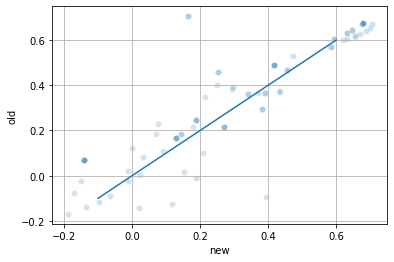

In [126]:
sns.scatterplot(data=vis_data.query("Feature == 'No AS'"), x='new', y='old', alpha=0.2)
plt.plot([-0.1,0.6],[-0.1,0.6])
plt.grid()
plt.show()

In [ ]:

train_info = ['P61073',0,True,0]
test_unip = train_info[0]
test_rep = train_info[1]
test_with_ala = train_info[2]
seed = int(train_info[3])
wkdir = '/data/gpfs/projects/punim0860/imputation/'


import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.ensemble import GradientBoostingRegressor
sys.path.append(f"{wkdir}project_modules")
import cdma.models as models


prep_data = pd.read_csv(f'{wkdir}data/prep_envfeat_211011+211029+v12.csv', index_col=0)
imp_ascan = pd.read_csv(f"../../05_all_demimp_spartan/data/{test_unip}_mat_AS_prep_dmsa.csv",
                        index_col=0, na_values='', keep_default_na=False).reset_index(drop=True)
dms_ascan = pd.merge(imp_ascan[['dms_id', 'position', 'aa2', 'dmsa_id', 'Ascan_id', 'AS_score', 'Ascan_score_avail']],
                     prep_data, on=['dms_id', 'position', 'aa2'], how='outer', validate='m:1')
dms_ascan['AS_score'] = dms_ascan['AS_score'].fillna(dms_ascan['AS_score'].dropna().mean())
dms_ascan['dmsa_id'] = dms_ascan['dms_id'] + '@' + dms_ascan['Ascan_id'].astype(str)
dms_ascan['Ascan_score_avail'] = ~dms_ascan['Ascan_id'].isna()

with open(f'{wkdir}data/feature_dictionary.txt', 'r') as file:
    feature = eval(file.read())['Envision']
    
# Data preprocessing.
dms_ascan = dms_ascan.reset_index(drop=True)

# Set training weight.
mut_count = dms_ascan[['uniprot_id', 'u_pos', 'aa2', 'score']].groupby(['uniprot_id', 'u_pos', 'aa2'], as_index=False).count()
mut_count['weight'] = 1 / mut_count['score']
mut_count.drop(columns='score', inplace=True)
dms_ascan = pd.merge(dms_ascan, mut_count, on=['uniprot_id', 'u_pos', 'aa2'], how='outer', validate='m:1')

# Separate training and testing data.
train_data = dms_ascan[dms_ascan['uniprot_id'] != test_unip]
test_data = dms_ascan[dms_ascan['uniprot_id'] == test_unip]

# Parameters setting.
search_space = [{'name':'n_estimators', 'type':'discrete', 'domain':np.arange(10, 51), 'dtype':int},
                {'name':'max_depth', 'type':'discrete', 'domain':np.arange(1, 81), 'dtype':int},
                {'name':'min_weight_fraction_leaf', 'type':'continuous', 'domain':(0.01,0.5), 'dtype':float}]
estimator = GradientBoostingRegressor(random_state=seed)

# Parameters preprocessing.
if test_with_ala:
    model_feature = feature+['AS_score']
    model_name = 'with_ala'
else:
    model_feature = feature.copy()
    model_name = 'nothing'
output_header = f"./log/{test_unip}_{model_name}_{test_rep}_"
bo_kwargs = {'num_iterations': 500, 'num_cores': 1, 'if_maximize': True, 'output_header': output_header,
             'random_seed': seed, 'max_time': 72000}
cv_kwargs = {'scoring': 'neg_mean_squared_error', 'cv': GroupKFold(30), 'n_jobs': 6}
cv_kwargs['groups'] = train_data['uniprot_id']
cv_kwargs['fit_params'] = {'sample_weight': train_data['weight']}

# Training.
models.monitor_process('./log/', f"{output_header[6:-1]} starts.", 0)
predictor = models.fit_best_estimator(search_space, estimator, train_data[model_feature], train_data['score'],
                                      cv_kwargs, bo_kwargs)
models.save_feature_importance(predictor, output_header)
models.save_tuned_hyperparameters(predictor, search_space, output_header)
models.save_compared_prediction(predictor, test_data, model_feature, 'score', output_header+'test_', info_col=["dmsa_id", "position", "aa2"])
models.monitor_process('./log/', f"{output_header[6:-1]} ends.", 0)

In [ ]:
train_info = ['P51681',0,True,0]
unip = train_info[0]
test_with_ala = train_info[2]
model = {True: 'with_as', False: 'no_as'}[test_with_ala]
seed = int(train_info[3])
wkdir = '/data/gpfs/projects/punim0860/imputation/'


import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import GradientBoostingRegressor
sys.path.append(f"{wkdir}data/cdma_code_data/cdma_module")
import models as models
import preproc as preproc


def add_training_weight(input_data):
    weight = input_data.groupby(['uniprot_id', 'u_pos', 'aa2'])['score'].count()
    weight = 1 / weight
    weight.name = 'weight'
    weighted_data = pd.merge(input_data, weight, left_on=['uniprot_id', 'u_pos', 'aa2'], right_index=True,
                             how='outer', validate='m:1').reset_index(drop=True)
    return weighted_data


DEMASK_FEATURES = ['entropy', 'log2f_var', 'matrix']


data_info = pd.read_csv(f'{wkdir}data/cdma_code_data/dataset_info.csv', index_col=0)
norm_as = pd.read_csv(f'{wkdir}data/cdma_code_data/normalized_alanine_scanning.csv')

# Pick AS subset that are highly compatibility with given DMS assay.
comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')

# Prepare DMS+AS data with Envision feature.
norm_dms_env = pd.read_csv(f'{wkdir}data/cdma_code_data/normalized_dms_Envision_features.csv', 
                           index_col=0, na_values=[''], keep_default_na=False)
dmsas_env = pd.merge(norm_dms_env, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                     on=['dms_id', 'u_pos'], how='left')
dmsas_env['dmsa_id'] = dmsas_env['dms_id'] + '@' + dmsas_env['Ascan_id'].astype(str)
dmsas_env['Ascan_score_avail'] = ~dmsas_env['AS_score'].isna()
dmsas_env = add_training_weight(dmsas_env)

# Preprocess data: impute missing values and encode categorical features.
features = ['aa1', 'aa2', 'wt_mut', 'aa1_polarity', 'aa2_polarity', 'aa1_PI','aa2_PI', 'deltaPI', 
            'Grantham', 'aa1_weight', 'aa2_weight', 'deltaWeight', 'aa1vol', 'aa2vol', 'deltavolume',
            'aa1_psic', 'aa2_psic', 'delta_psic', 'accessibility', 'dssp_sec_str', 'phi_psi_reg',
            'delta_solvent_accessibility', 'b_factor', 'mut_msa_congruency', 'seq_ind_closest_mut', 
            'mut_mut_msa_congruency', 'evolutionary_coupling_avg']
categ_feat = ['aa1', 'aa2', 'wt_mut', 'aa1_polarity', 'aa2_polarity', 'dssp_sec_str', 'phi_psi_reg']
numer_feat = [x for x in features if x not in categ_feat]
dmsas_env, encoded_col = preproc.impute_encode_features(dmsas_env, categ_feat, numer_feat+['AS_score'], ['aa1', 'aa2'])
envision_features = encoded_col + numer_feat

# Set parameters.
output_dir = './log/'
search_space = [{'name':'n_estimators', 'type':'discrete', 'domain':np.arange(10, 51), 'dtype':int},
                {'name':'max_depth', 'type':'discrete', 'domain':np.arange(1, 81), 'dtype':int},
                {'name':'min_weight_fraction_leaf', 'type':'continuous', 'domain':(0.01,0.5), 'dtype':float}]
bo_kwargs = {'num_iterations': 500, 'num_cores': 1, 'if_maximize': True, 'random_seed': seed, 'max_time': 72000}
cv_kwargs = {'scoring': 'neg_mean_squared_error', 'cv': GroupKFold(30), 'n_jobs': 6}

# LOPO
train_data = dmsas_env.query("uniprot_id != @unip")
test_data_ori = dmsas_env.query("uniprot_id == @unip")
cv_kwargs['fit_params'] = {'sample_weight': train_data['weight']}
cv_kwargs['groups'] = train_data['uniprot_id']

# Set model.
if model == 'with_as':
    model_features = envision_features + ['AS_score'] ########## Ascan_score_avail
else:
    model_features = envision_features.copy()
output_header = f"{output_dir}{unip}_{model}_"
bo_kwargs['output_header'] = output_header

# Training & testing.
models.monitor_process(output_dir, f"{output_header[len(output_dir):-1]} starts.", 0)
estimator = GradientBoostingRegressor(random_state=seed)
predictor = models.fit_best_estimator(search_space, estimator, train_data[model_features], 
                                      train_data['score'], cv_kwargs, bo_kwargs)
test_data = test_data_ori.copy()
test_data['pred_score'] = predictor.predict(test_data[model_features])

# Saving results.
test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")
models.save_feature_importance(predictor, output_header)
models.save_tuned_hyperparameters(predictor, search_space, output_header)
models.monitor_process(output_dir, f"{output_header[len(output_dir):-1]} ends.", 0)

# Replace AS with simulated scanning

Instead of using alanine scanning data, we want to investiagte how sacnning results on other substitution types may perform in our pipeline. Since low-throughput measurements of such variants were rare in our data, we used the DMS scores as a simulated single-residue scan for each amino acid.

To do this:
1. One amino acid is picked at a time for simulated scanning.
2. DMS scores for substitutions to this amino acid were picked up as simulated scanning scores.
3. The simulated scanning scores were merged with the __original DMS__ data and were imputed and encoded as the AS data.
4. The prediction model is built similar as previously mentioned.
5. During the evaluation process, the DMS scores of the chosen variant amino acid type were __excluded__ since they have already been used as feature values.
6. The process is iterated over all amino acids.

## Training & testing

In [14]:
def model_simulated_scanning(dms_simscan, encoded_col, scan_aa2):
    """ Run leave-one-protein-out cross-validation on predicting with simulated scanning data.
    """
    # LOPO CV
    for unip in dms_simscan['uniprot_id'].unique():
        train_data = dms_simscan.query("uniprot_id != @unip")
        test_data_ori = dms_simscan.query("uniprot_id == @unip")
        train_data, test_data_ori = train.refit_matrix_score(train_data, test_data_ori)
        
        for model in ['with_simscan', 'no_simscan']:
            if model == 'with_simscan':
                model_features = DEMASK_FEATURES + encoded_col + ['scan_score']
                model = scan_aa2
            elif scan_aa2 == 'A':
                model_features = DEMASK_FEATURES.copy()
            # Result of no simulated scanning score have nothing to do with scan_aa2, so the rest will be skipped.
            else: 
                continue
            output_header = f"../result/prediction/alternative_models/simulated_scan/{unip}_{model}_"

            estimator = LinearRegression(n_jobs=4)
            predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
            test_data = test_data_ori.copy()
            test_data['pred_score'] = predictor.predict(test_data[model_features])
            test_data[["dms_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")
    return

In [15]:
# Modelling. This may take about 30min on MacBook Pro 15-inch 2018.
for scan_aa2 in 'ACDEFGHIKLMNPQRSTVWY':
    # Pick DMS score of given variant type as simulated low-throughput scanning scores.
    sim_scan = norm_dms.query("aa2 == @scan_aa2")[['dms_id', 'position', 'score']]
    sim_scan.rename(columns={'score': 'scan_score'}, inplace=True)
    dms_simscan = pd.merge(norm_dms, sim_scan, on=['dms_id', 'position'], how='left', validate='m:1')
    
    # Impute, encode & weight.
    dms_simscan = preproc.impute_missing_value(dms_simscan, None, ['scan_score'])
    dms_simscan, encoded_col = preproc.encode_categorical_feature(dms_simscan, ['aa1', 'aa2'], ['aa1', 'aa2'])
    dms_simscan[encoded_col] = dms_simscan[encoded_col].mul(dms_simscan['scan_score'], axis='index')
    dms_simscan = train.add_training_weight(dms_simscan)
    
    model_simulated_scanning(dms_simscan, encoded_col, scan_aa2)

## Evaluation

In [23]:
# Result reading and evaluation.
simscan_perf = []
root = '../result/prediction/alternative_models/simulated_scan/'
for scan_aa2 in 'ACDEFGHIKLMNPQRSTVWYZ':
    if scan_aa2 == 'Z':  # Place holder
        model = 'no_simscan'
    else:
        model = scan_aa2
        
    onesim_result = pd.concat([pd.read_csv(f"{root}{unip}_{model}_prediction.csv", index_col=0) 
                               for unip in norm_dms.uniprot_id.unique()])
    onesim_result = onesim_result.query("aa2 != @scan_aa2")  # Remove scores used as feature already.
    
    # Calculate prediction performance by Spearman's correlation on each DMS dataset.
    onesim_perf = ana.subgroup_spearmanr(onesim_result, 'dms_id', 'score', 'pred_score')
    onesim_perf = onesim_perf.reset_index().rename(columns={'index': 'dms_id'})
    onesim_perf['scan_aa2'] = scan_aa2
    simscan_perf.append(onesim_perf)
simscan_perf = pd.concat(simscan_perf)

The predicton correlation for using each simulated scanning result (or not), measured by Spearman's ρ on each DMS data, creating __Figure S9__.

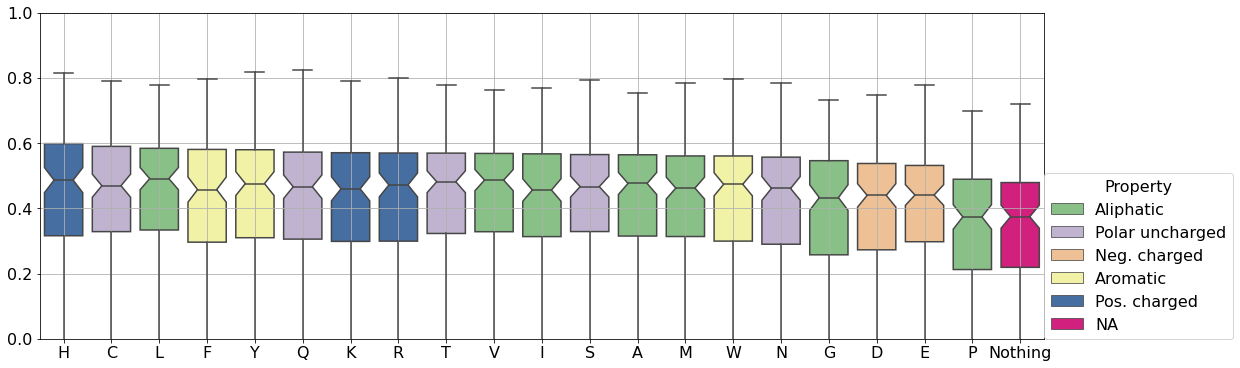

In [24]:
# Refine & add data info.
vis_data = simscan_perf.copy()
vis_data['scan_aa2'] = vis_data['scan_aa2'].replace({'Z': 'Nothing'})
vis_data['property'] = vis_data['scan_aa2'].map(AA_PROPERTY).fillna('NA')
    
fig, ax = plt.subplots(1,1,figsize=(18, 6))
fig.patch.set_facecolor('w')
order = list(vis_data.groupby('scan_aa2')[['rho']].quantile(0.75).sort_values('rho', ascending=False).index)
sns.boxplot(x='scan_aa2', y='rho', data=vis_data, hue='property', notch=True, dodge=False,
            whis=np.inf, ax=ax, order=order, palette='Accent')

# Aesthetics.
ax.legend(loc=[1,0], fontsize=16).set_title('Property',prop={'size':16})
ax.set_ylim([0,1])
ax.set_yticks([0.,0.2,0.4,0.6,0.8,1.])
ax.set_yticklabels([0.,0.2,0.4,0.6,0.8,1.], fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_ylabel('')
ax.set_xlabel('')
plt.grid()

plt.show()

# Boosting predictor

To deal with the sparsity of AS data, we tried to build the variant impact predictor in a boosting way:

To do this:
1. A first linear regression predictor was trained with all training DMS data using the three DeMaSk features __without AS data__, which is the same as the main control predictor.
2. Then the prediction error of is calculated by subtracting the predicted scores from DMS scores for training data.
3. After that, a second linear regression predictor was trained to __predict the error__, which uses the DeMaSk features as well as __AS data of high assay compatibility__.
4. The final prediction result is the sum of the outputs from these two predictors.

## Training & testing

In [16]:
# This part is the same as the data preparation for high compatibility filtering (P2-2.2.1)
# Pick AS subset that are highly compatibility with given DMS assay.
comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')

dms_comp_as = pd.merge(norm_dms, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                       on=['dms_id', 'u_pos'], how='left')
dms_comp_as['dmsa_id'] = dms_comp_as['dms_id'] + '@' + dms_comp_as['Ascan_id'].astype(str)
dms_comp_as['Ascan_score_avail'] = ~dms_comp_as['AS_score'].isna()
dms_comp_as, encoded_col = preproc_demask_dmsas_data(dms_comp_as)

In [17]:
def first_step_modelling(train_data_ori, test_data_ori, first_features):
    """First step of boosting prediction which uses no AS feature.
    """
    train_data = train_data_ori.copy()
    test_data = test_data_ori.copy()
    
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[first_features], train_data['score'], train_data['weight'])
    
    train_data['first_pred'] = predictor.predict(train_data[first_features])
    train_data['diff_pred'] = train_data['score'] - train_data['first_pred']
    
    test_data['first_pred'] = predictor.predict(test_data[first_features])
    test_data['diff_pred'] = test_data['score'] - test_data['first_pred']
    return train_data, test_data


def second_step_modelling(train_data_ori, test_data_ori, second_features):
    """Second step of boosting prediction which uses AS feature.
    """
    train_data = train_data_ori.copy()
    test_data = test_data_ori.copy()
    
    train_data = train_data[train_data['Ascan_score_avail']].copy()  # Limit to data with AS scores.
    train_data = train.add_training_weight(train_data.drop(columns='weight'))  # Reset weight.
    
    estimator = LinearRegression(n_jobs=1)
    predictor = estimator.fit(train_data[second_features], train_data['diff_pred'], train_data['weight'])
    
    train_data['second_pred'] = predictor.predict(train_data[second_features])
    train_data['final_pred'] = train_data['first_pred'] + train_data['second_pred']
    
    test_data['second_pred'] = predictor.predict(test_data[second_features])
    test_data['final_pred'] = test_data['first_pred'] + test_data['second_pred']
    return train_data, test_data

In [18]:
# Modelling.
first_features = DEMASK_FEATURES.copy()
second_features = DEMASK_FEATURES + encoded_col + ['AS_score']

# Leave-one-protein-out cross-validation.
for unip in dms_comp_as['uniprot_id'].unique():  
    train_data = dms_comp_as.query("uniprot_id != @unip").copy()
    test_data = dms_comp_as.query("uniprot_id == @unip").copy()
    train_data, test_data = train.refit_matrix_score(train_data, test_data)
            
    # First step: no AS feature.
    train_data, test_data = first_step_modelling(train_data, test_data, first_features)
    # Second step: with AS feature.
    train_data, test_data = second_step_modelling(train_data, test_data, second_features)
    
    # Saving.
    output_header = f"../result/prediction/alternative_models/boosting/{unip}_"
    test_data[["dmsa_id", "position", "aa2", "score", "final_pred", "first_pred"]].to_csv(f"{output_header}prediction.csv")

## Evaluation

The boosting result is evaluated the same as previously mentioned and compared with the previous _compatibility filtered_ result which is noted here as the _main result_, creating __Figure S12__.

In [25]:
# Data reading and evaluation.
root = '../result/prediction/alternative_models/boosting/'
boosting_result = pd.concat([pd.read_csv(f"{root}{unip}_prediction.csv", index_col=0) 
                             for unip in norm_dms.uniprot_id.unique()])
boost_perf = ana.subgroup_spearmanr(boosting_result, 'dmsa_id', 'score', 'final_pred')

In [27]:
# Prepare data for visualisation.
# Get (one-step) compatibility filtering result for comparison.
root = '../result/prediction/linear_as/compatible_as/'
comp_filt_result = pd.concat([pd.read_csv(f"{root}{unip}_with_as_prediction.csv", index_col=0) 
                             for unip in norm_dms.uniprot_id.unique()])
comp_filt_perf = ana.subgroup_spearmanr(comp_filt_result, 'dmsa_id', 'score', 'pred_score')

# Merge performance results.
bench_data = pd.merge(boost_perf, comp_filt_perf, left_index=True, right_index=True, validate='1:1', 
                      how='outer', suffixes=['_boost', '_onestep'])
bench_data = bench_data[bench_data.index.str[-4:] != '@nan']  # Remove data without available (filtered) AS score.
bench_data['Protein name'] = bench_data.index.map(data_info.groupby('dmsa_id').protein_name.first())
bench_data = bench_data.rename(columns={'size_boost': 'Size'})  # size_boost and size_onestep are the same.

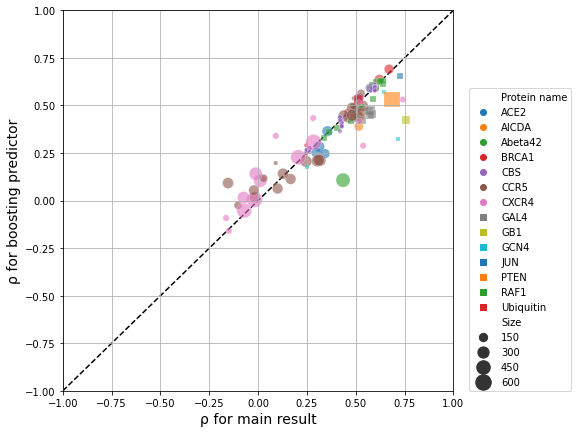

In [28]:
# Set makers.
order = np.sort(bench_data['Protein name'].unique())
half = int(len(order)/2)
markers = dict(zip(order, ['o']*half + ['s']*(len(order) - half)))

fig, ax = plt.subplots(1, 1, figsize=(7,7))
fig.patch.set_facecolor('w')
g = sns.scatterplot(data=bench_data, x='rho_onestep', y='rho_boost', size='Size', hue='Protein name', 
                    hue_order=order, style='Protein name', alpha=0.6, ax=ax, sizes=(15,250), 
                    palette="tab10", markers=markers)
ax.plot([-1,1],[-1,1], '--', c='k', zorder=0)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('ρ for main result', fontsize=14)
ax.set_ylabel('ρ for boosting predictor', fontsize=14)
ax.legend(loc=(1.04, 0))
ax.grid(zorder=0)
plt.show()

# Replace AS with DMS-Ala for training

Another potential approach to overcome the sparsity of AS data is by replacing the AS feature with the DMS scores on alanine substitutions (DMS-Ala) for the __training process__. Compared to AS data, DMS-Ala scores are available for most DMS variants. They also show reasonable correlation with the AS scores.

To do this:
1. For the __training data__, we take DMS-Ala scores for all DMS data we collected.
2. The DMS-Ala scores are merged with the original DMS data, replacing the real AS data.
3. DMS-Ala scores are imputed, encoded and included in model training just as what we did with AS data previously.
4. __But the testing data remain using AS scores for prediction.__

## Training & testing

In [19]:
# Data preparation

# Data for training, with DMS score of alanine substitution (DMS-Ala) score replacing AS score.
sim_scan = norm_dms.query("aa2 == 'A'")[['dms_id', 'position', 'score']]
sim_scan.rename(columns={'score': 'AS_score'}, inplace=True)  # Easier to interpret, should actually be DMS-Ala.
dms_simscan = pd.merge(norm_dms, sim_scan, on=['dms_id', 'position'], how='left', validate='m:1')
dms_simscan, encoded_col = preproc_demask_dmsas_data(dms_simscan)

# Data for testing, with AS scores kept.
# This part is the same as the data preparation for training with all AS data (P2-2.1).
all_as = norm_as.copy()
dms_all_as = pd.merge(norm_dms, all_as[['uniprot_id', 'u_pos', 'Ascan_id', 'AS_score']], 
                      on=['uniprot_id', 'u_pos'], how='left')
dms_all_as['dmsa_id'] = dms_all_as['dms_id'] + '@' + dms_all_as['Ascan_id'].astype(str)
dms_all_as['Ascan_score_avail'] = ~dms_all_as['AS_score'].isna()
dms_all_as = preproc.impute_missing_value(dms_all_as, None, ['AS_score'])
dms_all_as, encoded_col = preproc.encode_categorical_feature(dms_all_as, ['aa1', 'aa2'], ['aa1', 'aa2'])
dms_all_as[encoded_col] = dms_all_as[encoded_col].mul(dms_all_as['AS_score'], axis='index')

In [20]:
# Modelling
for unip in dms_simscan['uniprot_id'].unique():
    train_data = dms_simscan.query("uniprot_id != @unip")  # Train data use DMS-Ala score.
    test_data = dms_all_as.query("uniprot_id == @unip").copy()  # Test data use AS score.
    train_data, test_data = train.refit_matrix_score(train_data, test_data)

    model_features = DEMASK_FEATURES + encoded_col + ['AS_score']
    output_header = f"../result/prediction/alternative_models/dms-ala_train/{unip}_"
    estimator = LinearRegression(n_jobs=4)
    predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
    test_data['pred_score'] = predictor.predict(test_data[model_features])
    test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")

## Evaluation

The DMS-Ala training result is evaluated the same as previously mentioned and compared with the previous _compatibility filtered_ result which is noted here as the _main result_, creating __Figure S13__.

In [29]:
# Data reading and evaluation.
root = '../result/prediction/alternative_models/dms-ala_train/'
dmsala_result = pd.concat([pd.read_csv(f"{root}{unip}_prediction.csv", index_col=0) 
                             for unip in norm_dms.uniprot_id.unique()])
dmsala_perf = ana.subgroup_spearmanr(dmsala_result, 'dmsa_id', 'score', 'pred_score')

In [30]:
# Prepare data for visualisation.
# Get compatibility filtering (AS trained) result for comparison.
root = '../result/prediction/linear_as/compatible_as/'
comp_filt_result = pd.concat([pd.read_csv(f"{root}{unip}_with_as_prediction.csv", index_col=0) 
                             for unip in norm_dms.uniprot_id.unique()])
comp_filt_perf = ana.subgroup_spearmanr(comp_filt_result, 'dmsa_id', 'score', 'pred_score')

# Merge performance results.
# Merge on right, keeping highly comparable data only, for comparison purpose.
bench_data = pd.merge(dmsala_perf, comp_filt_perf, left_index=True, right_index=True, validate='1:1', 
                      how='right', suffixes=['_DMS-Alatrain', '_AStrain'])  
bench_data = bench_data[bench_data.index.str[-4:] != '@nan']  # Remove data without available (filtered) AS score.
bench_data['Protein name'] = bench_data.index.map(data_info.groupby('dmsa_id').protein_name.first())
bench_data = bench_data.rename(columns={'size_DMS-Alatrain': 'Size'})

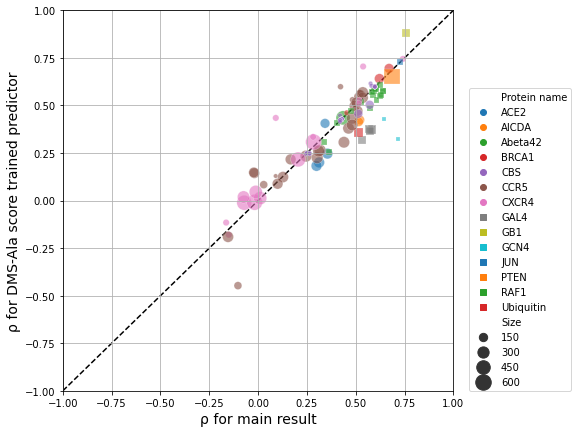

In [31]:
# Set makers.
order = np.sort(bench_data['Protein name'].unique())
half = int(len(order)/2)
markers = dict(zip(order, ['o']*half + ['s']*(len(order) - half)))

fig, ax = plt.subplots(1, 1, figsize=(7,7))
fig.patch.set_facecolor('w')
g = sns.scatterplot(data=bench_data, x='rho_AStrain', y='rho_DMS-Alatrain', size='Size', hue='Protein name', 
                    hue_order=order, style='Protein name', alpha=0.6, ax=ax, sizes=(15,250), 
                    palette="tab10", markers=markers)
ax.plot([-1,1],[-1,1], '--', c='k', zorder=0)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('ρ for main result', fontsize=14)
ax.set_ylabel('ρ for DMS-Ala score trained predictor', fontsize=14)
ax.legend(loc=(1.04, 0))
ax.grid(zorder=0)
plt.show()